In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.25,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_025_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1314873, 828)
(1314873, 8)
validation
(153265, 828)
(153265, 8)
test
(189545, 828)
(189545, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/132 [..............................] - ETA: 3:44 - loss: 2.3000 - STD: 0.0782 - MAE: 0.2172

  4/132 [..............................] - ETA: 2s - loss: 2.0836 - STD: 0.0886 - MAE: 0.2089  

  7/132 [>.............................] - ETA: 2s - loss: 2.0379 - STD: 0.0843 - MAE: 0.2085

 10/132 [=>............................] - ETA: 2s - loss: 2.0227 - STD: 0.0800 - MAE: 0.2088

 13/132 [=>............................] - ETA: 2s - loss: 2.0100 - STD: 0.0804 - MAE: 0.2084

 16/132 [==>...........................] - ETA: 2s - loss: 2.0007 - STD: 0.0806 - MAE: 0.2082

 19/132 [===>..........................] - ETA: 2s - loss: 1.9932 - STD: 0.0789 - MAE: 0.2082

 22/132 [====>.........................] - ETA: 2s - loss: 1.9881 - STD: 0.0772 - MAE: 0.2084

 25/132 [====>.........................] - ETA: 2s - loss: 1.9832 - STD: 0.0765 - MAE: 0.2083

 28/132 [=====>........................] - ETA: 2s - loss: 1.9782 - STD: 0.0765 - MAE: 0.2082

 31/132 [======>.......................] - ETA: 2s - loss: 1.9735 - STD: 0.0764 - MAE: 0.2080

 34/132 [======>.......................] - ETA: 2s - loss: 1.9693 - STD: 0.0761 - MAE: 0.2079

 37/132 [=======>......................] - ETA: 2s - loss: 1.9653 - STD: 0.0760 - MAE: 0.2078

 40/132 [========>.....................] - ETA: 2s - loss: 1.9604 - STD: 0.0761 - MAE: 0.2076

 43/132 [========>.....................] - ETA: 2s - loss: 1.9556 - STD: 0.0765 - MAE: 0.2073

 46/132 [=========>....................] - ETA: 1s - loss: 1.9506 - STD: 0.0770 - MAE: 0.2071

 49/132 [==========>...................] - ETA: 1s - loss: 1.9455 - STD: 0.0777 - MAE: 0.2067

 52/132 [==========>...................] - ETA: 1s - loss: 1.9400 - STD: 0.0783 - MAE: 0.2065

 55/132 [===========>..................] - ETA: 1s - loss: 1.9342 - STD: 0.0789 - MAE: 0.2062

 58/132 [============>.................] - ETA: 1s - loss: 1.9278 - STD: 0.0795 - MAE: 0.2058

 61/132 [============>.................] - ETA: 1s - loss: 1.9211 - STD: 0.0803 - MAE: 0.2055

 64/132 [=============>................] - ETA: 1s - loss: 1.9138 - STD: 0.0811 - MAE: 0.2051

 67/132 [==============>...............] - ETA: 1s - loss: 1.9064 - STD: 0.0819 - MAE: 0.2047

 70/132 [==============>...............] - ETA: 1s - loss: 1.8990 - STD: 0.0828 - MAE: 0.2043

 73/132 [===============>..............] - ETA: 1s - loss: 1.8911 - STD: 0.0836 - MAE: 0.2039

 76/132 [================>.............] - ETA: 1s - loss: 1.8832 - STD: 0.0846 - MAE: 0.2034

 79/132 [================>.............] - ETA: 1s - loss: 1.8750 - STD: 0.0855 - MAE: 0.2030

 82/132 [=================>............] - ETA: 1s - loss: 1.8669 - STD: 0.0866 - MAE: 0.2025

 85/132 [==================>...........] - ETA: 1s - loss: 1.8589 - STD: 0.0874 - MAE: 0.2021

 88/132 [===================>..........] - ETA: 0s - loss: 1.8510 - STD: 0.0884 - MAE: 0.2017

 91/132 [===================>..........] - ETA: 0s - loss: 1.8431 - STD: 0.0893 - MAE: 0.2013

 94/132 [====================>.........] - ETA: 0s - loss: 1.8352 - STD: 0.0903 - MAE: 0.2008

 97/132 [=====================>........] - ETA: 0s - loss: 1.8273 - STD: 0.0913 - MAE: 0.2004

100/132 [=====================>........] - ETA: 0s - loss: 1.8194 - STD: 0.0921 - MAE: 0.1999

103/132 [======================>.......] - ETA: 0s - loss: 1.8125 - STD: 0.0931 - MAE: 0.1994

106/132 [=======================>......] - ETA: 0s - loss: 1.8043 - STD: 0.0941 - MAE: 0.1990

109/132 [=======================>......] - ETA: 0s - loss: 1.7954 - STD: 0.0951 - MAE: 0.1984

112/132 [========================>.....] - ETA: 0s - loss: 1.7865 - STD: 0.0961 - MAE: 0.1979

115/132 [=========================>....] - ETA: 0s - loss: 1.7774 - STD: 0.0972 - MAE: 0.1973

118/132 [=========================>....] - ETA: 0s - loss: 1.7680 - STD: 0.0983 - MAE: 0.1968

121/132 [==========================>...] - ETA: 0s - loss: 1.7587 - STD: 0.0994 - MAE: 0.1962

124/132 [===========================>..] - ETA: 0s - loss: 1.7496 - STD: 0.1006 - MAE: 0.1956

127/132 [===========================>..] - ETA: 0s - loss: 1.7405 - STD: 0.1018 - MAE: 0.1950

130/132 [============================>.] - ETA: 0s - loss: 1.7315 - STD: 0.1029 - MAE: 0.1944

132/132 [==============================] - 6s 36ms/step - loss: 1.7256 - STD: 0.1037 - MAE: 0.1940 - val_loss: 1.3133 - val_STD: 0.1559 - val_MAE: 0.1654


Epoch 2/10000


  1/132 [..............................] - ETA: 6s - loss: 1.3320 - STD: 0.1549 - MAE: 0.1672

  4/132 [..............................] - ETA: 2s - loss: 1.3301 - STD: 0.1565 - MAE: 0.1665

  7/132 [>.............................] - ETA: 2s - loss: 1.3247 - STD: 0.1576 - MAE: 0.1659

 10/132 [=>............................] - ETA: 2s - loss: 1.3196 - STD: 0.1584 - MAE: 0.1654

 13/132 [=>............................] - ETA: 2s - loss: 1.3180 - STD: 0.1593 - MAE: 0.1651

 16/132 [==>...........................] - ETA: 2s - loss: 1.3142 - STD: 0.1601 - MAE: 0.1646

 19/132 [===>..........................] - ETA: 2s - loss: 1.3095 - STD: 0.1611 - MAE: 0.1641

 22/132 [====>.........................] - ETA: 2s - loss: 1.3049 - STD: 0.1621 - MAE: 0.1635

 25/132 [====>.........................] - ETA: 2s - loss: 1.3021 - STD: 0.1630 - MAE: 0.1630

 28/132 [=====>........................] - ETA: 2s - loss: 1.2989 - STD: 0.1635 - MAE: 0.1627

 31/132 [======>.......................] - ETA: 2s - loss: 1.2966 - STD: 0.1639 - MAE: 0.1625

 34/132 [======>.......................] - ETA: 2s - loss: 1.2941 - STD: 0.1644 - MAE: 0.1622

 37/132 [=======>......................] - ETA: 2s - loss: 1.2909 - STD: 0.1650 - MAE: 0.1618

 40/132 [========>.....................] - ETA: 2s - loss: 1.2883 - STD: 0.1655 - MAE: 0.1615

 43/132 [========>.....................] - ETA: 2s - loss: 1.2858 - STD: 0.1658 - MAE: 0.1613

 46/132 [=========>....................] - ETA: 1s - loss: 1.2837 - STD: 0.1663 - MAE: 0.1611

 49/132 [==========>...................] - ETA: 1s - loss: 1.2821 - STD: 0.1667 - MAE: 0.1609

 52/132 [==========>...................] - ETA: 1s - loss: 1.2806 - STD: 0.1672 - MAE: 0.1606

 55/132 [===========>..................] - ETA: 1s - loss: 1.2787 - STD: 0.1675 - MAE: 0.1604

 58/132 [============>.................] - ETA: 1s - loss: 1.2767 - STD: 0.1677 - MAE: 0.1603

 61/132 [============>.................] - ETA: 1s - loss: 1.2748 - STD: 0.1680 - MAE: 0.1601

 64/132 [=============>................] - ETA: 1s - loss: 1.2730 - STD: 0.1683 - MAE: 0.1599

 67/132 [==============>...............] - ETA: 1s - loss: 1.2712 - STD: 0.1686 - MAE: 0.1597

 70/132 [==============>...............] - ETA: 1s - loss: 1.2695 - STD: 0.1689 - MAE: 0.1596

 73/132 [===============>..............] - ETA: 1s - loss: 1.2679 - STD: 0.1691 - MAE: 0.1594

 76/132 [================>.............] - ETA: 1s - loss: 1.2661 - STD: 0.1694 - MAE: 0.1592

 79/132 [================>.............] - ETA: 1s - loss: 1.2644 - STD: 0.1698 - MAE: 0.1590

 82/132 [=================>............] - ETA: 1s - loss: 1.2629 - STD: 0.1700 - MAE: 0.1589

 85/132 [==================>...........] - ETA: 1s - loss: 1.2612 - STD: 0.1703 - MAE: 0.1587

 88/132 [===================>..........] - ETA: 0s - loss: 1.2595 - STD: 0.1706 - MAE: 0.1585

 91/132 [===================>..........] - ETA: 0s - loss: 1.2579 - STD: 0.1708 - MAE: 0.1584

 94/132 [====================>.........] - ETA: 0s - loss: 1.2562 - STD: 0.1710 - MAE: 0.1582

 97/132 [=====================>........] - ETA: 0s - loss: 1.2548 - STD: 0.1712 - MAE: 0.1581

100/132 [=====================>........] - ETA: 0s - loss: 1.2532 - STD: 0.1714 - MAE: 0.1579

103/132 [======================>.......] - ETA: 0s - loss: 1.2515 - STD: 0.1717 - MAE: 0.1578

106/132 [=======================>......] - ETA: 0s - loss: 1.2499 - STD: 0.1719 - MAE: 0.1576

109/132 [=======================>......] - ETA: 0s - loss: 1.2483 - STD: 0.1721 - MAE: 0.1575

112/132 [========================>.....] - ETA: 0s - loss: 1.2468 - STD: 0.1723 - MAE: 0.1573

115/132 [=========================>....] - ETA: 0s - loss: 1.2451 - STD: 0.1726 - MAE: 0.1571

118/132 [=========================>....] - ETA: 0s - loss: 1.2440 - STD: 0.1728 - MAE: 0.1570

121/132 [==========================>...] - ETA: 0s - loss: 1.2425 - STD: 0.1730 - MAE: 0.1569

124/132 [===========================>..] - ETA: 0s - loss: 1.2410 - STD: 0.1732 - MAE: 0.1567

127/132 [===========================>..] - ETA: 0s - loss: 1.2396 - STD: 0.1735 - MAE: 0.1566

130/132 [============================>.] - ETA: 0s - loss: 1.2382 - STD: 0.1737 - MAE: 0.1564

132/132 [==============================] - 3s 25ms/step - loss: 1.2374 - STD: 0.1738 - MAE: 0.1564 - val_loss: 1.1835 - val_STD: 0.1802 - val_MAE: 0.1503


Epoch 3/10000


  1/132 [..............................] - ETA: 6s - loss: 1.1688 - STD: 0.1813 - MAE: 0.1505

  4/132 [..............................] - ETA: 3s - loss: 1.1754 - STD: 0.1816 - MAE: 0.1509

  7/132 [>.............................] - ETA: 2s - loss: 1.1731 - STD: 0.1830 - MAE: 0.1502

 10/132 [=>............................] - ETA: 2s - loss: 1.1719 - STD: 0.1834 - MAE: 0.1499

 13/132 [=>............................] - ETA: 2s - loss: 1.1744 - STD: 0.1833 - MAE: 0.1501

 16/132 [==>...........................] - ETA: 2s - loss: 1.1759 - STD: 0.1830 - MAE: 0.1503

 19/132 [===>..........................] - ETA: 2s - loss: 1.1759 - STD: 0.1830 - MAE: 0.1503

 22/132 [====>.........................] - ETA: 2s - loss: 1.1749 - STD: 0.1833 - MAE: 0.1501

 25/132 [====>.........................] - ETA: 2s - loss: 1.1724 - STD: 0.1835 - MAE: 0.1499

 28/132 [=====>........................] - ETA: 2s - loss: 1.1706 - STD: 0.1837 - MAE: 0.1498

 31/132 [======>.......................] - ETA: 2s - loss: 1.1701 - STD: 0.1839 - MAE: 0.1497

 34/132 [======>.......................] - ETA: 2s - loss: 1.1684 - STD: 0.1841 - MAE: 0.1495

 37/132 [=======>......................] - ETA: 2s - loss: 1.1675 - STD: 0.1842 - MAE: 0.1494

 40/132 [========>.....................] - ETA: 2s - loss: 1.1667 - STD: 0.1843 - MAE: 0.1494

 43/132 [========>.....................] - ETA: 2s - loss: 1.1661 - STD: 0.1844 - MAE: 0.1493

 46/132 [=========>....................] - ETA: 1s - loss: 1.1659 - STD: 0.1845 - MAE: 0.1492

 49/132 [==========>...................] - ETA: 1s - loss: 1.1652 - STD: 0.1846 - MAE: 0.1491

 52/132 [==========>...................] - ETA: 1s - loss: 1.1647 - STD: 0.1848 - MAE: 0.1491

 55/132 [===========>..................] - ETA: 1s - loss: 1.1644 - STD: 0.1849 - MAE: 0.1490

 58/132 [============>.................] - ETA: 1s - loss: 1.1635 - STD: 0.1851 - MAE: 0.1489

 61/132 [============>.................] - ETA: 1s - loss: 1.1626 - STD: 0.1852 - MAE: 0.1488

 64/132 [=============>................] - ETA: 1s - loss: 1.1617 - STD: 0.1853 - MAE: 0.1487

 67/132 [==============>...............] - ETA: 1s - loss: 1.1610 - STD: 0.1854 - MAE: 0.1486

 70/132 [==============>...............] - ETA: 1s - loss: 1.1603 - STD: 0.1855 - MAE: 0.1486

 73/132 [===============>..............] - ETA: 1s - loss: 1.1595 - STD: 0.1856 - MAE: 0.1485

 76/132 [================>.............] - ETA: 1s - loss: 1.1581 - STD: 0.1858 - MAE: 0.1484

 79/132 [================>.............] - ETA: 1s - loss: 1.1572 - STD: 0.1859 - MAE: 0.1483

 82/132 [=================>............] - ETA: 1s - loss: 1.1564 - STD: 0.1860 - MAE: 0.1482

 85/132 [==================>...........] - ETA: 1s - loss: 1.1558 - STD: 0.1861 - MAE: 0.1481

 88/132 [===================>..........] - ETA: 1s - loss: 1.1548 - STD: 0.1862 - MAE: 0.1480

 91/132 [===================>..........] - ETA: 0s - loss: 1.1543 - STD: 0.1863 - MAE: 0.1480

 94/132 [====================>.........] - ETA: 0s - loss: 1.1537 - STD: 0.1864 - MAE: 0.1479

 97/132 [=====================>........] - ETA: 0s - loss: 1.1528 - STD: 0.1865 - MAE: 0.1478

100/132 [=====================>........] - ETA: 0s - loss: 1.1515 - STD: 0.1866 - MAE: 0.1477

103/132 [======================>.......] - ETA: 0s - loss: 1.1505 - STD: 0.1868 - MAE: 0.1476

106/132 [=======================>......] - ETA: 0s - loss: 1.1499 - STD: 0.1869 - MAE: 0.1475

109/132 [=======================>......] - ETA: 0s - loss: 1.1486 - STD: 0.1870 - MAE: 0.1474

112/132 [========================>.....] - ETA: 0s - loss: 1.1477 - STD: 0.1871 - MAE: 0.1473

115/132 [=========================>....] - ETA: 0s - loss: 1.1465 - STD: 0.1873 - MAE: 0.1472

118/132 [=========================>....] - ETA: 0s - loss: 1.1458 - STD: 0.1874 - MAE: 0.1471

121/132 [==========================>...] - ETA: 0s - loss: 1.1449 - STD: 0.1875 - MAE: 0.1470

124/132 [===========================>..] - ETA: 0s - loss: 1.1442 - STD: 0.1876 - MAE: 0.1470

127/132 [===========================>..] - ETA: 0s - loss: 1.1435 - STD: 0.1877 - MAE: 0.1469

130/132 [============================>.] - ETA: 0s - loss: 1.1429 - STD: 0.1878 - MAE: 0.1468

132/132 [==============================] - 3s 25ms/step - loss: 1.1423 - STD: 0.1879 - MAE: 0.1468 - val_loss: 1.1359 - val_STD: 0.1898 - val_MAE: 0.1449


Epoch 4/10000


  1/132 [..............................] - ETA: 6s - loss: 1.1305 - STD: 0.1901 - MAE: 0.1455

  4/132 [..............................] - ETA: 3s - loss: 1.1207 - STD: 0.1924 - MAE: 0.1441

  7/132 [>.............................] - ETA: 2s - loss: 1.1222 - STD: 0.1922 - MAE: 0.1442

 10/132 [=>............................] - ETA: 2s - loss: 1.1227 - STD: 0.1923 - MAE: 0.1443

 13/132 [=>............................] - ETA: 2s - loss: 1.1254 - STD: 0.1926 - MAE: 0.1443

 16/132 [==>...........................] - ETA: 2s - loss: 1.1226 - STD: 0.1925 - MAE: 0.1442

 19/132 [===>..........................] - ETA: 2s - loss: 1.1194 - STD: 0.1923 - MAE: 0.1441

 22/132 [====>.........................] - ETA: 2s - loss: 1.1166 - STD: 0.1924 - MAE: 0.1439

 25/132 [====>.........................] - ETA: 2s - loss: 1.1140 - STD: 0.1926 - MAE: 0.1437

 28/132 [=====>........................] - ETA: 2s - loss: 1.1125 - STD: 0.1927 - MAE: 0.1435

 31/132 [======>.......................] - ETA: 2s - loss: 1.1096 - STD: 0.1929 - MAE: 0.1433

 34/132 [======>.......................] - ETA: 2s - loss: 1.1068 - STD: 0.1931 - MAE: 0.1431

 37/132 [=======>......................] - ETA: 2s - loss: 1.1052 - STD: 0.1933 - MAE: 0.1429

 40/132 [========>.....................] - ETA: 2s - loss: 1.1046 - STD: 0.1934 - MAE: 0.1428

 43/132 [========>.....................] - ETA: 2s - loss: 1.1031 - STD: 0.1936 - MAE: 0.1427

 46/132 [=========>....................] - ETA: 1s - loss: 1.1015 - STD: 0.1937 - MAE: 0.1425

 49/132 [==========>...................] - ETA: 1s - loss: 1.1006 - STD: 0.1938 - MAE: 0.1424

 52/132 [==========>...................] - ETA: 1s - loss: 1.0994 - STD: 0.1939 - MAE: 0.1423

 55/132 [===========>..................] - ETA: 1s - loss: 1.0990 - STD: 0.1940 - MAE: 0.1422

 58/132 [============>.................] - ETA: 1s - loss: 1.0981 - STD: 0.1941 - MAE: 0.1421

 61/132 [============>.................] - ETA: 1s - loss: 1.0971 - STD: 0.1942 - MAE: 0.1420

 64/132 [=============>................] - ETA: 1s - loss: 1.0958 - STD: 0.1944 - MAE: 0.1419

 67/132 [==============>...............] - ETA: 1s - loss: 1.0949 - STD: 0.1945 - MAE: 0.1418

 70/132 [==============>...............] - ETA: 1s - loss: 1.0939 - STD: 0.1945 - MAE: 0.1417

 73/132 [===============>..............] - ETA: 1s - loss: 1.0935 - STD: 0.1947 - MAE: 0.1417

 76/132 [================>.............] - ETA: 1s - loss: 1.0929 - STD: 0.1948 - MAE: 0.1416

 79/132 [================>.............] - ETA: 1s - loss: 1.0922 - STD: 0.1948 - MAE: 0.1415

 82/132 [=================>............] - ETA: 1s - loss: 1.0916 - STD: 0.1949 - MAE: 0.1415

 85/132 [==================>...........] - ETA: 1s - loss: 1.0909 - STD: 0.1950 - MAE: 0.1414

 88/132 [===================>..........] - ETA: 1s - loss: 1.0907 - STD: 0.1952 - MAE: 0.1413

 91/132 [===================>..........] - ETA: 0s - loss: 1.0895 - STD: 0.1952 - MAE: 0.1412

 94/132 [====================>.........] - ETA: 0s - loss: 1.0887 - STD: 0.1954 - MAE: 0.1411

 97/132 [=====================>........] - ETA: 0s - loss: 1.0880 - STD: 0.1955 - MAE: 0.1411

100/132 [=====================>........] - ETA: 0s - loss: 1.0875 - STD: 0.1956 - MAE: 0.1410

103/132 [======================>.......] - ETA: 0s - loss: 1.0872 - STD: 0.1957 - MAE: 0.1409

106/132 [=======================>......] - ETA: 0s - loss: 1.0868 - STD: 0.1958 - MAE: 0.1409

109/132 [=======================>......] - ETA: 0s - loss: 1.0862 - STD: 0.1958 - MAE: 0.1408

112/132 [========================>.....] - ETA: 0s - loss: 1.0854 - STD: 0.1959 - MAE: 0.1407

115/132 [=========================>....] - ETA: 0s - loss: 1.0847 - STD: 0.1960 - MAE: 0.1407

118/132 [=========================>....] - ETA: 0s - loss: 1.0839 - STD: 0.1961 - MAE: 0.1406

121/132 [==========================>...] - ETA: 0s - loss: 1.0833 - STD: 0.1961 - MAE: 0.1405

124/132 [===========================>..] - ETA: 0s - loss: 1.0829 - STD: 0.1962 - MAE: 0.1405

127/132 [===========================>..] - ETA: 0s - loss: 1.0821 - STD: 0.1963 - MAE: 0.1404

130/132 [============================>.] - ETA: 0s - loss: 1.0815 - STD: 0.1964 - MAE: 0.1403

132/132 [==============================] - 3s 25ms/step - loss: 1.0813 - STD: 0.1964 - MAE: 0.1403 - val_loss: 1.0840 - val_STD: 0.1969 - val_MAE: 0.1385


Epoch 5/10000


  1/132 [..............................] - ETA: 6s - loss: 1.0424 - STD: 0.1986 - MAE: 0.1373

  4/132 [..............................] - ETA: 2s - loss: 1.0558 - STD: 0.1996 - MAE: 0.1377

  7/132 [>.............................] - ETA: 2s - loss: 1.0608 - STD: 0.2000 - MAE: 0.1377

 10/132 [=>............................] - ETA: 2s - loss: 1.0594 - STD: 0.2002 - MAE: 0.1376

 13/132 [=>............................] - ETA: 2s - loss: 1.0550 - STD: 0.2004 - MAE: 0.1373

 15/132 [==>...........................] - ETA: 2s - loss: 1.0543 - STD: 0.2004 - MAE: 0.1373

 18/132 [===>..........................] - ETA: 2s - loss: 1.0532 - STD: 0.2005 - MAE: 0.1371

 21/132 [===>..........................] - ETA: 2s - loss: 1.0524 - STD: 0.2003 - MAE: 0.1372

 24/132 [====>.........................] - ETA: 2s - loss: 1.0500 - STD: 0.2004 - MAE: 0.1370

 27/132 [=====>........................] - ETA: 2s - loss: 1.0491 - STD: 0.2005 - MAE: 0.1369

 30/132 [=====>........................] - ETA: 2s - loss: 1.0487 - STD: 0.2007 - MAE: 0.1368

 33/132 [======>.......................] - ETA: 2s - loss: 1.0485 - STD: 0.2008 - MAE: 0.1368

 36/132 [=======>......................] - ETA: 2s - loss: 1.0495 - STD: 0.2009 - MAE: 0.1368

 39/132 [=======>......................] - ETA: 2s - loss: 1.0508 - STD: 0.2009 - MAE: 0.1368

 42/132 [========>.....................] - ETA: 2s - loss: 1.0524 - STD: 0.2009 - MAE: 0.1369

 45/132 [=========>....................] - ETA: 2s - loss: 1.0532 - STD: 0.2010 - MAE: 0.1370

 47/132 [=========>....................] - ETA: 1s - loss: 1.0529 - STD: 0.2011 - MAE: 0.1369

 50/132 [==========>...................] - ETA: 1s - loss: 1.0521 - STD: 0.2011 - MAE: 0.1369

 53/132 [===========>..................] - ETA: 1s - loss: 1.0514 - STD: 0.2011 - MAE: 0.1369

 56/132 [===========>..................] - ETA: 1s - loss: 1.0512 - STD: 0.2011 - MAE: 0.1368

 59/132 [============>.................] - ETA: 1s - loss: 1.0503 - STD: 0.2012 - MAE: 0.1368

 62/132 [=============>................] - ETA: 1s - loss: 1.0498 - STD: 0.2012 - MAE: 0.1367

 65/132 [=============>................] - ETA: 1s - loss: 1.0490 - STD: 0.2012 - MAE: 0.1367

 68/132 [==============>...............] - ETA: 1s - loss: 1.0482 - STD: 0.2013 - MAE: 0.1366

 71/132 [===============>..............] - ETA: 1s - loss: 1.0472 - STD: 0.2013 - MAE: 0.1366

 74/132 [===============>..............] - ETA: 1s - loss: 1.0465 - STD: 0.2014 - MAE: 0.1365

 77/132 [================>.............] - ETA: 1s - loss: 1.0458 - STD: 0.2014 - MAE: 0.1364

 80/132 [=================>............] - ETA: 1s - loss: 1.0454 - STD: 0.2015 - MAE: 0.1364

 83/132 [=================>............] - ETA: 1s - loss: 1.0445 - STD: 0.2016 - MAE: 0.1363

 86/132 [==================>...........] - ETA: 1s - loss: 1.0439 - STD: 0.2017 - MAE: 0.1362

 89/132 [===================>..........] - ETA: 0s - loss: 1.0434 - STD: 0.2018 - MAE: 0.1362

 92/132 [===================>..........] - ETA: 0s - loss: 1.0428 - STD: 0.2018 - MAE: 0.1361

 95/132 [====================>.........] - ETA: 0s - loss: 1.0420 - STD: 0.2019 - MAE: 0.1360

 98/132 [=====================>........] - ETA: 0s - loss: 1.0411 - STD: 0.2019 - MAE: 0.1360

101/132 [=====================>........] - ETA: 0s - loss: 1.0410 - STD: 0.2020 - MAE: 0.1359

104/132 [======================>.......] - ETA: 0s - loss: 1.0402 - STD: 0.2021 - MAE: 0.1359

107/132 [=======================>......] - ETA: 0s - loss: 1.0395 - STD: 0.2022 - MAE: 0.1358

110/132 [========================>.....] - ETA: 0s - loss: 1.0389 - STD: 0.2022 - MAE: 0.1357

113/132 [========================>.....] - ETA: 0s - loss: 1.0390 - STD: 0.2023 - MAE: 0.1357

116/132 [=========================>....] - ETA: 0s - loss: 1.0392 - STD: 0.2024 - MAE: 0.1357

119/132 [==========================>...] - ETA: 0s - loss: 1.0389 - STD: 0.2025 - MAE: 0.1356

122/132 [==========================>...] - ETA: 0s - loss: 1.0382 - STD: 0.2025 - MAE: 0.1356

125/132 [===========================>..] - ETA: 0s - loss: 1.0376 - STD: 0.2026 - MAE: 0.1355

128/132 [============================>.] - ETA: 0s - loss: 1.0371 - STD: 0.2026 - MAE: 0.1355

131/132 [============================>.] - ETA: 0s - loss: 1.0366 - STD: 0.2027 - MAE: 0.1354

132/132 [==============================] - 3s 25ms/step - loss: 1.0364 - STD: 0.2027 - MAE: 0.1354 - val_loss: 1.0512 - val_STD: 0.2018 - val_MAE: 0.1352


Epoch 6/10000


  1/132 [..............................] - ETA: 6s - loss: 1.0301 - STD: 0.2037 - MAE: 0.1348

  3/132 [..............................] - ETA: 3s - loss: 1.0195 - STD: 0.2051 - MAE: 0.1336

  6/132 [>.............................] - ETA: 3s - loss: 1.0086 - STD: 0.2051 - MAE: 0.1330

  9/132 [=>............................] - ETA: 2s - loss: 1.0085 - STD: 0.2050 - MAE: 0.1330

 12/132 [=>............................] - ETA: 2s - loss: 1.0079 - STD: 0.2051 - MAE: 0.1329

 15/132 [==>...........................] - ETA: 2s - loss: 1.0076 - STD: 0.2053 - MAE: 0.1328

 18/132 [===>..........................] - ETA: 2s - loss: 1.0079 - STD: 0.2055 - MAE: 0.1327

 21/132 [===>..........................] - ETA: 2s - loss: 1.0108 - STD: 0.2057 - MAE: 0.1328

 24/132 [====>.........................] - ETA: 2s - loss: 1.0130 - STD: 0.2056 - MAE: 0.1329

 27/132 [=====>........................] - ETA: 2s - loss: 1.0148 - STD: 0.2056 - MAE: 0.1330

 30/132 [=====>........................] - ETA: 2s - loss: 1.0160 - STD: 0.2057 - MAE: 0.1330

 33/132 [======>.......................] - ETA: 2s - loss: 1.0172 - STD: 0.2058 - MAE: 0.1330

 36/132 [=======>......................] - ETA: 2s - loss: 1.0170 - STD: 0.2058 - MAE: 0.1330

 39/132 [=======>......................] - ETA: 2s - loss: 1.0154 - STD: 0.2059 - MAE: 0.1329

 42/132 [========>.....................] - ETA: 2s - loss: 1.0144 - STD: 0.2059 - MAE: 0.1329

 45/132 [=========>....................] - ETA: 1s - loss: 1.0135 - STD: 0.2060 - MAE: 0.1328

 48/132 [=========>....................] - ETA: 1s - loss: 1.0129 - STD: 0.2059 - MAE: 0.1328

 51/132 [==========>...................] - ETA: 1s - loss: 1.0130 - STD: 0.2059 - MAE: 0.1328

 54/132 [===========>..................] - ETA: 1s - loss: 1.0125 - STD: 0.2060 - MAE: 0.1327

 57/132 [===========>..................] - ETA: 1s - loss: 1.0117 - STD: 0.2061 - MAE: 0.1327

 60/132 [============>.................] - ETA: 1s - loss: 1.0107 - STD: 0.2061 - MAE: 0.1326

 63/132 [=============>................] - ETA: 1s - loss: 1.0106 - STD: 0.2061 - MAE: 0.1326

 66/132 [==============>...............] - ETA: 1s - loss: 1.0101 - STD: 0.2062 - MAE: 0.1325

 69/132 [==============>...............] - ETA: 1s - loss: 1.0106 - STD: 0.2062 - MAE: 0.1326

 72/132 [===============>..............] - ETA: 1s - loss: 1.0105 - STD: 0.2063 - MAE: 0.1325

 75/132 [================>.............] - ETA: 1s - loss: 1.0106 - STD: 0.2064 - MAE: 0.1325

 78/132 [================>.............] - ETA: 1s - loss: 1.0103 - STD: 0.2064 - MAE: 0.1325

 81/132 [=================>............] - ETA: 1s - loss: 1.0098 - STD: 0.2064 - MAE: 0.1325

 84/132 [==================>...........] - ETA: 1s - loss: 1.0097 - STD: 0.2064 - MAE: 0.1325

 87/132 [==================>...........] - ETA: 1s - loss: 1.0093 - STD: 0.2065 - MAE: 0.1324

 90/132 [===================>..........] - ETA: 0s - loss: 1.0090 - STD: 0.2065 - MAE: 0.1324

 93/132 [====================>.........] - ETA: 0s - loss: 1.0087 - STD: 0.2065 - MAE: 0.1324

 96/132 [====================>.........] - ETA: 0s - loss: 1.0083 - STD: 0.2066 - MAE: 0.1323

 99/132 [=====================>........] - ETA: 0s - loss: 1.0081 - STD: 0.2066 - MAE: 0.1323

102/132 [======================>.......] - ETA: 0s - loss: 1.0074 - STD: 0.2066 - MAE: 0.1323

105/132 [======================>.......] - ETA: 0s - loss: 1.0070 - STD: 0.2066 - MAE: 0.1322

108/132 [=======================>......] - ETA: 0s - loss: 1.0066 - STD: 0.2067 - MAE: 0.1322

111/132 [========================>.....] - ETA: 0s - loss: 1.0064 - STD: 0.2067 - MAE: 0.1322

114/132 [========================>.....] - ETA: 0s - loss: 1.0060 - STD: 0.2067 - MAE: 0.1321

117/132 [=========================>....] - ETA: 0s - loss: 1.0054 - STD: 0.2068 - MAE: 0.1321

120/132 [==========================>...] - ETA: 0s - loss: 1.0049 - STD: 0.2069 - MAE: 0.1320

123/132 [==========================>...] - ETA: 0s - loss: 1.0047 - STD: 0.2069 - MAE: 0.1320

126/132 [===========================>..] - ETA: 0s - loss: 1.0043 - STD: 0.2069 - MAE: 0.1320

129/132 [============================>.] - ETA: 0s - loss: 1.0040 - STD: 0.2070 - MAE: 0.1319

132/132 [==============================] - ETA: 0s - loss: 1.0036 - STD: 0.2070 - MAE: 0.1319

132/132 [==============================] - 3s 25ms/step - loss: 1.0036 - STD: 0.2070 - MAE: 0.1319 - val_loss: 1.0305 - val_STD: 0.2061 - val_MAE: 0.1326


Epoch 7/10000


  1/132 [..............................] - ETA: 5s - loss: 0.9990 - STD: 0.2081 - MAE: 0.1315

  4/132 [..............................] - ETA: 3s - loss: 0.9872 - STD: 0.2087 - MAE: 0.1304

  6/132 [>.............................] - ETA: 3s - loss: 0.9949 - STD: 0.2088 - MAE: 0.1308

  9/132 [=>............................] - ETA: 3s - loss: 0.9979 - STD: 0.2090 - MAE: 0.1308

 11/132 [=>............................] - ETA: 3s - loss: 0.9971 - STD: 0.2090 - MAE: 0.1308

 13/132 [=>............................] - ETA: 3s - loss: 0.9969 - STD: 0.2090 - MAE: 0.1307

 16/132 [==>...........................] - ETA: 2s - loss: 0.9935 - STD: 0.2090 - MAE: 0.1306

 19/132 [===>..........................] - ETA: 2s - loss: 0.9945 - STD: 0.2090 - MAE: 0.1306

 22/132 [====>.........................] - ETA: 2s - loss: 0.9934 - STD: 0.2089 - MAE: 0.1306

 25/132 [====>.........................] - ETA: 2s - loss: 0.9925 - STD: 0.2089 - MAE: 0.1305

 28/132 [=====>........................] - ETA: 2s - loss: 0.9930 - STD: 0.2090 - MAE: 0.1306

 31/132 [======>.......................] - ETA: 2s - loss: 0.9938 - STD: 0.2091 - MAE: 0.1306

 34/132 [======>.......................] - ETA: 2s - loss: 0.9948 - STD: 0.2092 - MAE: 0.1305

 37/132 [=======>......................] - ETA: 2s - loss: 0.9947 - STD: 0.2092 - MAE: 0.1305

 40/132 [========>.....................] - ETA: 2s - loss: 0.9944 - STD: 0.2093 - MAE: 0.1305

 43/132 [========>.....................] - ETA: 2s - loss: 0.9944 - STD: 0.2093 - MAE: 0.1305

 46/132 [=========>....................] - ETA: 2s - loss: 0.9949 - STD: 0.2092 - MAE: 0.1305

 49/132 [==========>...................] - ETA: 1s - loss: 0.9951 - STD: 0.2093 - MAE: 0.1306

 52/132 [==========>...................] - ETA: 1s - loss: 0.9951 - STD: 0.2093 - MAE: 0.1305

 55/132 [===========>..................] - ETA: 1s - loss: 0.9948 - STD: 0.2093 - MAE: 0.1305

 58/132 [============>.................] - ETA: 1s - loss: 0.9947 - STD: 0.2092 - MAE: 0.1305

 61/132 [============>.................] - ETA: 1s - loss: 0.9945 - STD: 0.2092 - MAE: 0.1305

 64/132 [=============>................] - ETA: 1s - loss: 0.9942 - STD: 0.2092 - MAE: 0.1305

 67/132 [==============>...............] - ETA: 1s - loss: 0.9938 - STD: 0.2092 - MAE: 0.1305

 70/132 [==============>...............] - ETA: 1s - loss: 0.9930 - STD: 0.2092 - MAE: 0.1304

 73/132 [===============>..............] - ETA: 1s - loss: 0.9918 - STD: 0.2093 - MAE: 0.1304

 76/132 [================>.............] - ETA: 1s - loss: 0.9916 - STD: 0.2093 - MAE: 0.1303

 79/132 [================>.............] - ETA: 1s - loss: 0.9909 - STD: 0.2093 - MAE: 0.1303

 82/132 [=================>............] - ETA: 1s - loss: 0.9903 - STD: 0.2093 - MAE: 0.1303

 85/132 [==================>...........] - ETA: 1s - loss: 0.9895 - STD: 0.2093 - MAE: 0.1302

 88/132 [===================>..........] - ETA: 1s - loss: 0.9892 - STD: 0.2094 - MAE: 0.1302

 91/132 [===================>..........] - ETA: 0s - loss: 0.9882 - STD: 0.2094 - MAE: 0.1301

 94/132 [====================>.........] - ETA: 0s - loss: 0.9877 - STD: 0.2095 - MAE: 0.1301

 97/132 [=====================>........] - ETA: 0s - loss: 0.9871 - STD: 0.2095 - MAE: 0.1300

100/132 [=====================>........] - ETA: 0s - loss: 0.9868 - STD: 0.2095 - MAE: 0.1300

103/132 [======================>.......] - ETA: 0s - loss: 0.9866 - STD: 0.2096 - MAE: 0.1300

106/132 [=======================>......] - ETA: 0s - loss: 0.9864 - STD: 0.2096 - MAE: 0.1299

109/132 [=======================>......] - ETA: 0s - loss: 0.9864 - STD: 0.2097 - MAE: 0.1299

112/132 [========================>.....] - ETA: 0s - loss: 0.9861 - STD: 0.2097 - MAE: 0.1299

115/132 [=========================>....] - ETA: 0s - loss: 0.9860 - STD: 0.2097 - MAE: 0.1299

118/132 [=========================>....] - ETA: 0s - loss: 0.9856 - STD: 0.2098 - MAE: 0.1298

121/132 [==========================>...] - ETA: 0s - loss: 0.9859 - STD: 0.2098 - MAE: 0.1298

124/132 [===========================>..] - ETA: 0s - loss: 0.9858 - STD: 0.2098 - MAE: 0.1298

127/132 [===========================>..] - ETA: 0s - loss: 0.9855 - STD: 0.2099 - MAE: 0.1298

130/132 [============================>.] - ETA: 0s - loss: 0.9856 - STD: 0.2099 - MAE: 0.1297

132/132 [==============================] - 3s 26ms/step - loss: 0.9854 - STD: 0.2099 - MAE: 0.1297 - val_loss: 1.0175 - val_STD: 0.2096 - val_MAE: 0.1303


Epoch 8/10000


  1/132 [..............................] - ETA: 6s - loss: 0.9693 - STD: 0.2125 - MAE: 0.1279

  4/132 [..............................] - ETA: 2s - loss: 0.9604 - STD: 0.2114 - MAE: 0.1277

  7/132 [>.............................] - ETA: 2s - loss: 0.9615 - STD: 0.2108 - MAE: 0.1280

 10/132 [=>............................] - ETA: 2s - loss: 0.9611 - STD: 0.2111 - MAE: 0.1279

 13/132 [=>............................] - ETA: 2s - loss: 0.9610 - STD: 0.2111 - MAE: 0.1279

 16/132 [==>...........................] - ETA: 2s - loss: 0.9627 - STD: 0.2111 - MAE: 0.1280

 19/132 [===>..........................] - ETA: 2s - loss: 0.9649 - STD: 0.2113 - MAE: 0.1280

 22/132 [====>.........................] - ETA: 2s - loss: 0.9648 - STD: 0.2114 - MAE: 0.1280

 25/132 [====>.........................] - ETA: 2s - loss: 0.9641 - STD: 0.2114 - MAE: 0.1280

 28/132 [=====>........................] - ETA: 2s - loss: 0.9641 - STD: 0.2114 - MAE: 0.1279

 31/132 [======>.......................] - ETA: 2s - loss: 0.9633 - STD: 0.2115 - MAE: 0.1278

 34/132 [======>.......................] - ETA: 2s - loss: 0.9637 - STD: 0.2115 - MAE: 0.1279

 37/132 [=======>......................] - ETA: 2s - loss: 0.9626 - STD: 0.2115 - MAE: 0.1278

 40/132 [========>.....................] - ETA: 2s - loss: 0.9619 - STD: 0.2116 - MAE: 0.1277

 43/132 [========>.....................] - ETA: 2s - loss: 0.9614 - STD: 0.2117 - MAE: 0.1277

 46/132 [=========>....................] - ETA: 1s - loss: 0.9614 - STD: 0.2117 - MAE: 0.1277

 49/132 [==========>...................] - ETA: 1s - loss: 0.9615 - STD: 0.2117 - MAE: 0.1276

 52/132 [==========>...................] - ETA: 1s - loss: 0.9619 - STD: 0.2118 - MAE: 0.1276

 55/132 [===========>..................] - ETA: 1s - loss: 0.9623 - STD: 0.2119 - MAE: 0.1276

 58/132 [============>.................] - ETA: 1s - loss: 0.9617 - STD: 0.2119 - MAE: 0.1276

 61/132 [============>.................] - ETA: 1s - loss: 0.9614 - STD: 0.2120 - MAE: 0.1275

 64/132 [=============>................] - ETA: 1s - loss: 0.9613 - STD: 0.2121 - MAE: 0.1275

 67/132 [==============>...............] - ETA: 1s - loss: 0.9610 - STD: 0.2121 - MAE: 0.1274

 70/132 [==============>...............] - ETA: 1s - loss: 0.9607 - STD: 0.2122 - MAE: 0.1274

 73/132 [===============>..............] - ETA: 1s - loss: 0.9601 - STD: 0.2122 - MAE: 0.1273

 76/132 [================>.............] - ETA: 1s - loss: 0.9595 - STD: 0.2123 - MAE: 0.1273

 79/132 [================>.............] - ETA: 1s - loss: 0.9592 - STD: 0.2123 - MAE: 0.1273

 82/132 [=================>............] - ETA: 1s - loss: 0.9589 - STD: 0.2123 - MAE: 0.1272

 85/132 [==================>...........] - ETA: 1s - loss: 0.9586 - STD: 0.2123 - MAE: 0.1272

 88/132 [===================>..........] - ETA: 1s - loss: 0.9584 - STD: 0.2124 - MAE: 0.1272

 91/132 [===================>..........] - ETA: 0s - loss: 0.9586 - STD: 0.2124 - MAE: 0.1272

 94/132 [====================>.........] - ETA: 0s - loss: 0.9588 - STD: 0.2124 - MAE: 0.1272

 97/132 [=====================>........] - ETA: 0s - loss: 0.9588 - STD: 0.2125 - MAE: 0.1271

100/132 [=====================>........] - ETA: 0s - loss: 0.9591 - STD: 0.2126 - MAE: 0.1272

103/132 [======================>.......] - ETA: 0s - loss: 0.9589 - STD: 0.2126 - MAE: 0.1271

106/132 [=======================>......] - ETA: 0s - loss: 0.9588 - STD: 0.2126 - MAE: 0.1271

109/132 [=======================>......] - ETA: 0s - loss: 0.9586 - STD: 0.2126 - MAE: 0.1271

112/132 [========================>.....] - ETA: 0s - loss: 0.9582 - STD: 0.2127 - MAE: 0.1271

115/132 [=========================>....] - ETA: 0s - loss: 0.9580 - STD: 0.2127 - MAE: 0.1270

118/132 [=========================>....] - ETA: 0s - loss: 0.9580 - STD: 0.2127 - MAE: 0.1270

121/132 [==========================>...] - ETA: 0s - loss: 0.9582 - STD: 0.2128 - MAE: 0.1270

124/132 [===========================>..] - ETA: 0s - loss: 0.9581 - STD: 0.2128 - MAE: 0.1270

127/132 [===========================>..] - ETA: 0s - loss: 0.9578 - STD: 0.2128 - MAE: 0.1270

130/132 [============================>.] - ETA: 0s - loss: 0.9575 - STD: 0.2128 - MAE: 0.1269

132/132 [==============================] - 3s 25ms/step - loss: 0.9573 - STD: 0.2129 - MAE: 0.1269 - val_loss: 1.0322 - val_STD: 0.2124 - val_MAE: 0.1290


Epoch 9/10000


  1/132 [..............................] - ETA: 7s - loss: 0.9629 - STD: 0.2131 - MAE: 0.1273

  4/132 [..............................] - ETA: 2s - loss: 0.9482 - STD: 0.2145 - MAE: 0.1258

  7/132 [>.............................] - ETA: 2s - loss: 0.9415 - STD: 0.2147 - MAE: 0.1252

 10/132 [=>............................] - ETA: 2s - loss: 0.9411 - STD: 0.2146 - MAE: 0.1252

 13/132 [=>............................] - ETA: 2s - loss: 0.9438 - STD: 0.2147 - MAE: 0.1254

 16/132 [==>...........................] - ETA: 2s - loss: 0.9447 - STD: 0.2147 - MAE: 0.1254

 19/132 [===>..........................] - ETA: 2s - loss: 0.9463 - STD: 0.2146 - MAE: 0.1255

 22/132 [====>.........................] - ETA: 2s - loss: 0.9512 - STD: 0.2146 - MAE: 0.1258

 25/132 [====>.........................] - ETA: 2s - loss: 0.9530 - STD: 0.2145 - MAE: 0.1260

 28/132 [=====>........................] - ETA: 2s - loss: 0.9528 - STD: 0.2144 - MAE: 0.1260

 31/132 [======>.......................] - ETA: 2s - loss: 0.9515 - STD: 0.2145 - MAE: 0.1259

 34/132 [======>.......................] - ETA: 2s - loss: 0.9506 - STD: 0.2144 - MAE: 0.1259

 37/132 [=======>......................] - ETA: 2s - loss: 0.9493 - STD: 0.2144 - MAE: 0.1258

 40/132 [========>.....................] - ETA: 2s - loss: 0.9486 - STD: 0.2144 - MAE: 0.1258

 43/132 [========>.....................] - ETA: 2s - loss: 0.9478 - STD: 0.2143 - MAE: 0.1258

 46/132 [=========>....................] - ETA: 1s - loss: 0.9469 - STD: 0.2143 - MAE: 0.1257

 49/132 [==========>...................] - ETA: 1s - loss: 0.9465 - STD: 0.2144 - MAE: 0.1257

 52/132 [==========>...................] - ETA: 1s - loss: 0.9466 - STD: 0.2145 - MAE: 0.1256

 55/132 [===========>..................] - ETA: 1s - loss: 0.9468 - STD: 0.2145 - MAE: 0.1256

 58/132 [============>.................] - ETA: 1s - loss: 0.9496 - STD: 0.2146 - MAE: 0.1257

 61/132 [============>.................] - ETA: 1s - loss: 0.9505 - STD: 0.2146 - MAE: 0.1258

 64/132 [=============>................] - ETA: 1s - loss: 0.9513 - STD: 0.2147 - MAE: 0.1258

 67/132 [==============>...............] - ETA: 1s - loss: 0.9516 - STD: 0.2147 - MAE: 0.1258

 70/132 [==============>...............] - ETA: 1s - loss: 0.9520 - STD: 0.2147 - MAE: 0.1258

 73/132 [===============>..............] - ETA: 1s - loss: 0.9521 - STD: 0.2147 - MAE: 0.1258

 76/132 [================>.............] - ETA: 1s - loss: 0.9516 - STD: 0.2147 - MAE: 0.1258

 79/132 [================>.............] - ETA: 1s - loss: 0.9511 - STD: 0.2147 - MAE: 0.1258

 82/132 [=================>............] - ETA: 1s - loss: 0.9506 - STD: 0.2147 - MAE: 0.1258

 85/132 [==================>...........] - ETA: 1s - loss: 0.9499 - STD: 0.2147 - MAE: 0.1257

 88/132 [===================>..........] - ETA: 0s - loss: 0.9494 - STD: 0.2147 - MAE: 0.1257

 91/132 [===================>..........] - ETA: 0s - loss: 0.9487 - STD: 0.2147 - MAE: 0.1256

 94/132 [====================>.........] - ETA: 0s - loss: 0.9485 - STD: 0.2147 - MAE: 0.1256

 97/132 [=====================>........] - ETA: 0s - loss: 0.9478 - STD: 0.2147 - MAE: 0.1256

100/132 [=====================>........] - ETA: 0s - loss: 0.9471 - STD: 0.2147 - MAE: 0.1255

103/132 [======================>.......] - ETA: 0s - loss: 0.9467 - STD: 0.2147 - MAE: 0.1255

106/132 [=======================>......] - ETA: 0s - loss: 0.9462 - STD: 0.2148 - MAE: 0.1255

109/132 [=======================>......] - ETA: 0s - loss: 0.9461 - STD: 0.2148 - MAE: 0.1255

112/132 [========================>.....] - ETA: 0s - loss: 0.9459 - STD: 0.2148 - MAE: 0.1254

115/132 [=========================>....] - ETA: 0s - loss: 0.9452 - STD: 0.2149 - MAE: 0.1254

118/132 [=========================>....] - ETA: 0s - loss: 0.9447 - STD: 0.2149 - MAE: 0.1253

121/132 [==========================>...] - ETA: 0s - loss: 0.9443 - STD: 0.2149 - MAE: 0.1253

124/132 [===========================>..] - ETA: 0s - loss: 0.9440 - STD: 0.2150 - MAE: 0.1253

127/132 [===========================>..] - ETA: 0s - loss: 0.9437 - STD: 0.2150 - MAE: 0.1253

130/132 [============================>.] - ETA: 0s - loss: 0.9436 - STD: 0.2150 - MAE: 0.1252

132/132 [==============================] - 3s 25ms/step - loss: 0.9438 - STD: 0.2151 - MAE: 0.1252 - val_loss: 1.0220 - val_STD: 0.2140 - val_MAE: 0.1285


Epoch 10/10000


  1/132 [..............................] - ETA: 6s - loss: 0.9531 - STD: 0.2168 - MAE: 0.1250

  4/132 [..............................] - ETA: 2s - loss: 0.9353 - STD: 0.2172 - MAE: 0.1239

  7/132 [>.............................] - ETA: 2s - loss: 0.9382 - STD: 0.2171 - MAE: 0.1240

 10/132 [=>............................] - ETA: 2s - loss: 0.9412 - STD: 0.2170 - MAE: 0.1243

 13/132 [=>............................] - ETA: 2s - loss: 0.9386 - STD: 0.2170 - MAE: 0.1241

 16/132 [==>...........................] - ETA: 2s - loss: 0.9377 - STD: 0.2170 - MAE: 0.1240

 19/132 [===>..........................] - ETA: 2s - loss: 0.9380 - STD: 0.2169 - MAE: 0.1241

 22/132 [====>.........................] - ETA: 2s - loss: 0.9365 - STD: 0.2169 - MAE: 0.1240

 25/132 [====>.........................] - ETA: 2s - loss: 0.9358 - STD: 0.2168 - MAE: 0.1240

 28/132 [=====>........................] - ETA: 2s - loss: 0.9376 - STD: 0.2169 - MAE: 0.1241

 31/132 [======>.......................] - ETA: 2s - loss: 0.9380 - STD: 0.2169 - MAE: 0.1241

 34/132 [======>.......................] - ETA: 2s - loss: 0.9377 - STD: 0.2169 - MAE: 0.1241

 37/132 [=======>......................] - ETA: 2s - loss: 0.9372 - STD: 0.2168 - MAE: 0.1241

 40/132 [========>.....................] - ETA: 2s - loss: 0.9368 - STD: 0.2168 - MAE: 0.1241

 43/132 [========>.....................] - ETA: 2s - loss: 0.9366 - STD: 0.2168 - MAE: 0.1241

 46/132 [=========>....................] - ETA: 1s - loss: 0.9369 - STD: 0.2167 - MAE: 0.1241

 49/132 [==========>...................] - ETA: 1s - loss: 0.9379 - STD: 0.2167 - MAE: 0.1242

 52/132 [==========>...................] - ETA: 1s - loss: 0.9373 - STD: 0.2166 - MAE: 0.1242

 55/132 [===========>..................] - ETA: 1s - loss: 0.9365 - STD: 0.2166 - MAE: 0.1241

 58/132 [============>.................] - ETA: 1s - loss: 0.9353 - STD: 0.2166 - MAE: 0.1241

 61/132 [============>.................] - ETA: 1s - loss: 0.9344 - STD: 0.2166 - MAE: 0.1240

 64/132 [=============>................] - ETA: 1s - loss: 0.9336 - STD: 0.2167 - MAE: 0.1239

 67/132 [==============>...............] - ETA: 1s - loss: 0.9334 - STD: 0.2167 - MAE: 0.1239

 70/132 [==============>...............] - ETA: 1s - loss: 0.9329 - STD: 0.2167 - MAE: 0.1239

 73/132 [===============>..............] - ETA: 1s - loss: 0.9328 - STD: 0.2168 - MAE: 0.1239

 76/132 [================>.............] - ETA: 1s - loss: 0.9320 - STD: 0.2168 - MAE: 0.1238

 79/132 [================>.............] - ETA: 1s - loss: 0.9314 - STD: 0.2169 - MAE: 0.1237

 82/132 [=================>............] - ETA: 1s - loss: 0.9312 - STD: 0.2169 - MAE: 0.1237

 85/132 [==================>...........] - ETA: 1s - loss: 0.9308 - STD: 0.2169 - MAE: 0.1237

 88/132 [===================>..........] - ETA: 0s - loss: 0.9304 - STD: 0.2169 - MAE: 0.1237

 91/132 [===================>..........] - ETA: 0s - loss: 0.9300 - STD: 0.2169 - MAE: 0.1237

 94/132 [====================>.........] - ETA: 0s - loss: 0.9299 - STD: 0.2169 - MAE: 0.1236

 97/132 [=====================>........] - ETA: 0s - loss: 0.9302 - STD: 0.2170 - MAE: 0.1236

100/132 [=====================>........] - ETA: 0s - loss: 0.9303 - STD: 0.2170 - MAE: 0.1237

102/132 [======================>.......] - ETA: 0s - loss: 0.9308 - STD: 0.2170 - MAE: 0.1237

105/132 [======================>.......] - ETA: 0s - loss: 0.9308 - STD: 0.2170 - MAE: 0.1237

108/132 [=======================>......] - ETA: 0s - loss: 0.9304 - STD: 0.2170 - MAE: 0.1236

111/132 [========================>.....] - ETA: 0s - loss: 0.9302 - STD: 0.2170 - MAE: 0.1236

114/132 [========================>.....] - ETA: 0s - loss: 0.9299 - STD: 0.2170 - MAE: 0.1236

117/132 [=========================>....] - ETA: 0s - loss: 0.9296 - STD: 0.2170 - MAE: 0.1236

120/132 [==========================>...] - ETA: 0s - loss: 0.9295 - STD: 0.2170 - MAE: 0.1236

123/132 [==========================>...] - ETA: 0s - loss: 0.9292 - STD: 0.2170 - MAE: 0.1236

126/132 [===========================>..] - ETA: 0s - loss: 0.9287 - STD: 0.2170 - MAE: 0.1235

129/132 [============================>.] - ETA: 0s - loss: 0.9282 - STD: 0.2171 - MAE: 0.1235

132/132 [==============================] - ETA: 0s - loss: 0.9279 - STD: 0.2171 - MAE: 0.1235

132/132 [==============================] - 3s 25ms/step - loss: 0.9279 - STD: 0.2171 - MAE: 0.1235 - val_loss: 1.0177 - val_STD: 0.2150 - val_MAE: 0.1268


Epoch 11/10000


  1/132 [..............................] - ETA: 5s - loss: 0.8973 - STD: 0.2184 - MAE: 0.1212

  4/132 [..............................] - ETA: 2s - loss: 0.9041 - STD: 0.2179 - MAE: 0.1217

  7/132 [>.............................] - ETA: 2s - loss: 0.9080 - STD: 0.2183 - MAE: 0.1217

 10/132 [=>............................] - ETA: 2s - loss: 0.9112 - STD: 0.2187 - MAE: 0.1218

 13/132 [=>............................] - ETA: 2s - loss: 0.9146 - STD: 0.2189 - MAE: 0.1219

 16/132 [==>...........................] - ETA: 2s - loss: 0.9233 - STD: 0.2190 - MAE: 0.1223

 19/132 [===>..........................] - ETA: 2s - loss: 0.9232 - STD: 0.2191 - MAE: 0.1223

 22/132 [====>.........................] - ETA: 2s - loss: 0.9260 - STD: 0.2189 - MAE: 0.1226

 25/132 [====>.........................] - ETA: 2s - loss: 0.9243 - STD: 0.2187 - MAE: 0.1226

 28/132 [=====>........................] - ETA: 2s - loss: 0.9231 - STD: 0.2187 - MAE: 0.1225

 31/132 [======>.......................] - ETA: 2s - loss: 0.9228 - STD: 0.2186 - MAE: 0.1225

 34/132 [======>.......................] - ETA: 2s - loss: 0.9218 - STD: 0.2186 - MAE: 0.1225

 37/132 [=======>......................] - ETA: 2s - loss: 0.9217 - STD: 0.2186 - MAE: 0.1225

 40/132 [========>.....................] - ETA: 2s - loss: 0.9202 - STD: 0.2186 - MAE: 0.1224

 43/132 [========>.....................] - ETA: 2s - loss: 0.9200 - STD: 0.2186 - MAE: 0.1224

 46/132 [=========>....................] - ETA: 1s - loss: 0.9197 - STD: 0.2187 - MAE: 0.1223

 49/132 [==========>...................] - ETA: 1s - loss: 0.9205 - STD: 0.2187 - MAE: 0.1224

 52/132 [==========>...................] - ETA: 1s - loss: 0.9199 - STD: 0.2187 - MAE: 0.1223

 55/132 [===========>..................] - ETA: 1s - loss: 0.9200 - STD: 0.2187 - MAE: 0.1223

 58/132 [============>.................] - ETA: 1s - loss: 0.9206 - STD: 0.2187 - MAE: 0.1223

 61/132 [============>.................] - ETA: 1s - loss: 0.9206 - STD: 0.2187 - MAE: 0.1223

 64/132 [=============>................] - ETA: 1s - loss: 0.9212 - STD: 0.2187 - MAE: 0.1223

 67/132 [==============>...............] - ETA: 1s - loss: 0.9207 - STD: 0.2187 - MAE: 0.1223

 70/132 [==============>...............] - ETA: 1s - loss: 0.9203 - STD: 0.2187 - MAE: 0.1223

 73/132 [===============>..............] - ETA: 1s - loss: 0.9201 - STD: 0.2187 - MAE: 0.1223

 76/132 [================>.............] - ETA: 1s - loss: 0.9198 - STD: 0.2187 - MAE: 0.1223

 79/132 [================>.............] - ETA: 1s - loss: 0.9194 - STD: 0.2187 - MAE: 0.1223

 82/132 [=================>............] - ETA: 1s - loss: 0.9186 - STD: 0.2187 - MAE: 0.1222

 85/132 [==================>...........] - ETA: 1s - loss: 0.9181 - STD: 0.2187 - MAE: 0.1222

 88/132 [===================>..........] - ETA: 0s - loss: 0.9179 - STD: 0.2187 - MAE: 0.1222

 91/132 [===================>..........] - ETA: 0s - loss: 0.9182 - STD: 0.2188 - MAE: 0.1222

 94/132 [====================>.........] - ETA: 0s - loss: 0.9184 - STD: 0.2188 - MAE: 0.1222

 97/132 [=====================>........] - ETA: 0s - loss: 0.9185 - STD: 0.2188 - MAE: 0.1222

100/132 [=====================>........] - ETA: 0s - loss: 0.9183 - STD: 0.2188 - MAE: 0.1222

103/132 [======================>.......] - ETA: 0s - loss: 0.9183 - STD: 0.2188 - MAE: 0.1222

106/132 [=======================>......] - ETA: 0s - loss: 0.9183 - STD: 0.2188 - MAE: 0.1222

109/132 [=======================>......] - ETA: 0s - loss: 0.9183 - STD: 0.2188 - MAE: 0.1222

112/132 [========================>.....] - ETA: 0s - loss: 0.9180 - STD: 0.2188 - MAE: 0.1222

115/132 [=========================>....] - ETA: 0s - loss: 0.9178 - STD: 0.2188 - MAE: 0.1221

118/132 [=========================>....] - ETA: 0s - loss: 0.9181 - STD: 0.2188 - MAE: 0.1222

121/132 [==========================>...] - ETA: 0s - loss: 0.9176 - STD: 0.2188 - MAE: 0.1221

124/132 [===========================>..] - ETA: 0s - loss: 0.9175 - STD: 0.2189 - MAE: 0.1221

127/132 [===========================>..] - ETA: 0s - loss: 0.9175 - STD: 0.2189 - MAE: 0.1221

130/132 [============================>.] - ETA: 0s - loss: 0.9178 - STD: 0.2189 - MAE: 0.1221

132/132 [==============================] - 3s 25ms/step - loss: 0.9177 - STD: 0.2189 - MAE: 0.1221 - val_loss: 0.9908 - val_STD: 0.2170 - val_MAE: 0.1265


Epoch 12/10000


  1/132 [..............................] - ETA: 6s - loss: 0.9213 - STD: 0.2207 - MAE: 0.1217

  4/132 [..............................] - ETA: 2s - loss: 0.9226 - STD: 0.2198 - MAE: 0.1221

  7/132 [>.............................] - ETA: 2s - loss: 0.9288 - STD: 0.2197 - MAE: 0.1223

 10/132 [=>............................] - ETA: 2s - loss: 0.9283 - STD: 0.2195 - MAE: 0.1225

 13/132 [=>............................] - ETA: 2s - loss: 0.9284 - STD: 0.2193 - MAE: 0.1225

 16/132 [==>...........................] - ETA: 2s - loss: 0.9251 - STD: 0.2194 - MAE: 0.1223

 19/132 [===>..........................] - ETA: 2s - loss: 0.9231 - STD: 0.2195 - MAE: 0.1222

 22/132 [====>.........................] - ETA: 2s - loss: 0.9218 - STD: 0.2193 - MAE: 0.1222

 25/132 [====>.........................] - ETA: 2s - loss: 0.9205 - STD: 0.2192 - MAE: 0.1221

 28/132 [=====>........................] - ETA: 2s - loss: 0.9197 - STD: 0.2191 - MAE: 0.1221

 31/132 [======>.......................] - ETA: 2s - loss: 0.9171 - STD: 0.2192 - MAE: 0.1219

 34/132 [======>.......................] - ETA: 2s - loss: 0.9162 - STD: 0.2192 - MAE: 0.1218

 37/132 [=======>......................] - ETA: 2s - loss: 0.9154 - STD: 0.2193 - MAE: 0.1218

 40/132 [========>.....................] - ETA: 2s - loss: 0.9145 - STD: 0.2193 - MAE: 0.1217

 43/132 [========>.....................] - ETA: 2s - loss: 0.9131 - STD: 0.2193 - MAE: 0.1216

 46/132 [=========>....................] - ETA: 1s - loss: 0.9128 - STD: 0.2194 - MAE: 0.1216

 49/132 [==========>...................] - ETA: 1s - loss: 0.9122 - STD: 0.2195 - MAE: 0.1215

 52/132 [==========>...................] - ETA: 1s - loss: 0.9115 - STD: 0.2195 - MAE: 0.1215

 55/132 [===========>..................] - ETA: 1s - loss: 0.9111 - STD: 0.2196 - MAE: 0.1214

 58/132 [============>.................] - ETA: 1s - loss: 0.9116 - STD: 0.2197 - MAE: 0.1214

 61/132 [============>.................] - ETA: 1s - loss: 0.9113 - STD: 0.2197 - MAE: 0.1214

 64/132 [=============>................] - ETA: 1s - loss: 0.9110 - STD: 0.2197 - MAE: 0.1214

 67/132 [==============>...............] - ETA: 1s - loss: 0.9106 - STD: 0.2197 - MAE: 0.1214

 70/132 [==============>...............] - ETA: 1s - loss: 0.9098 - STD: 0.2197 - MAE: 0.1213

 73/132 [===============>..............] - ETA: 1s - loss: 0.9097 - STD: 0.2197 - MAE: 0.1213

 76/132 [================>.............] - ETA: 1s - loss: 0.9092 - STD: 0.2197 - MAE: 0.1213

 79/132 [================>.............] - ETA: 1s - loss: 0.9086 - STD: 0.2198 - MAE: 0.1212

 82/132 [=================>............] - ETA: 1s - loss: 0.9088 - STD: 0.2198 - MAE: 0.1212

 85/132 [==================>...........] - ETA: 1s - loss: 0.9085 - STD: 0.2198 - MAE: 0.1212

 88/132 [===================>..........] - ETA: 0s - loss: 0.9082 - STD: 0.2198 - MAE: 0.1212

 91/132 [===================>..........] - ETA: 0s - loss: 0.9076 - STD: 0.2198 - MAE: 0.1211

 94/132 [====================>.........] - ETA: 0s - loss: 0.9071 - STD: 0.2199 - MAE: 0.1211

 97/132 [=====================>........] - ETA: 0s - loss: 0.9069 - STD: 0.2199 - MAE: 0.1211

100/132 [=====================>........] - ETA: 0s - loss: 0.9067 - STD: 0.2200 - MAE: 0.1210

103/132 [======================>.......] - ETA: 0s - loss: 0.9071 - STD: 0.2200 - MAE: 0.1210

106/132 [=======================>......] - ETA: 0s - loss: 0.9071 - STD: 0.2200 - MAE: 0.1210

109/132 [=======================>......] - ETA: 0s - loss: 0.9070 - STD: 0.2201 - MAE: 0.1210

112/132 [========================>.....] - ETA: 0s - loss: 0.9068 - STD: 0.2201 - MAE: 0.1210

115/132 [=========================>....] - ETA: 0s - loss: 0.9067 - STD: 0.2201 - MAE: 0.1210

118/132 [=========================>....] - ETA: 0s - loss: 0.9065 - STD: 0.2201 - MAE: 0.1209

121/132 [==========================>...] - ETA: 0s - loss: 0.9066 - STD: 0.2201 - MAE: 0.1209

124/132 [===========================>..] - ETA: 0s - loss: 0.9070 - STD: 0.2202 - MAE: 0.1210

127/132 [===========================>..] - ETA: 0s - loss: 0.9071 - STD: 0.2202 - MAE: 0.1209

130/132 [============================>.] - ETA: 0s - loss: 0.9066 - STD: 0.2202 - MAE: 0.1209

132/132 [==============================] - 3s 25ms/step - loss: 0.9062 - STD: 0.2202 - MAE: 0.1209 - val_loss: 0.9910 - val_STD: 0.2170 - val_MAE: 0.1256


Epoch 13/10000


  1/132 [..............................] - ETA: 6s - loss: 0.8909 - STD: 0.2202 - MAE: 0.1202

  4/132 [..............................] - ETA: 3s - loss: 0.9070 - STD: 0.2205 - MAE: 0.1210

  7/132 [>.............................] - ETA: 2s - loss: 0.9042 - STD: 0.2206 - MAE: 0.1207

 10/132 [=>............................] - ETA: 2s - loss: 0.9006 - STD: 0.2209 - MAE: 0.1203

 13/132 [=>............................] - ETA: 2s - loss: 0.9030 - STD: 0.2209 - MAE: 0.1205

 16/132 [==>...........................] - ETA: 2s - loss: 0.9013 - STD: 0.2210 - MAE: 0.1203

 19/132 [===>..........................] - ETA: 2s - loss: 0.9000 - STD: 0.2209 - MAE: 0.1202

 22/132 [====>.........................] - ETA: 2s - loss: 0.9022 - STD: 0.2209 - MAE: 0.1204

 25/132 [====>.........................] - ETA: 2s - loss: 0.9032 - STD: 0.2209 - MAE: 0.1204

 28/132 [=====>........................] - ETA: 2s - loss: 0.9022 - STD: 0.2210 - MAE: 0.1203

 31/132 [======>.......................] - ETA: 2s - loss: 0.9022 - STD: 0.2209 - MAE: 0.1204

 34/132 [======>.......................] - ETA: 2s - loss: 0.9014 - STD: 0.2209 - MAE: 0.1203

 37/132 [=======>......................] - ETA: 2s - loss: 0.9011 - STD: 0.2209 - MAE: 0.1203

 40/132 [========>.....................] - ETA: 2s - loss: 0.9003 - STD: 0.2209 - MAE: 0.1202

 43/132 [========>.....................] - ETA: 2s - loss: 0.8994 - STD: 0.2210 - MAE: 0.1202

 46/132 [=========>....................] - ETA: 1s - loss: 0.8989 - STD: 0.2209 - MAE: 0.1201

 49/132 [==========>...................] - ETA: 1s - loss: 0.8980 - STD: 0.2210 - MAE: 0.1201

 52/132 [==========>...................] - ETA: 1s - loss: 0.8973 - STD: 0.2210 - MAE: 0.1200

 55/132 [===========>..................] - ETA: 1s - loss: 0.8974 - STD: 0.2211 - MAE: 0.1200

 58/132 [============>.................] - ETA: 1s - loss: 0.8964 - STD: 0.2211 - MAE: 0.1199

 61/132 [============>.................] - ETA: 1s - loss: 0.8957 - STD: 0.2212 - MAE: 0.1199

 64/132 [=============>................] - ETA: 1s - loss: 0.8958 - STD: 0.2212 - MAE: 0.1199

 67/132 [==============>...............] - ETA: 1s - loss: 0.8953 - STD: 0.2212 - MAE: 0.1198

 70/132 [==============>...............] - ETA: 1s - loss: 0.8956 - STD: 0.2213 - MAE: 0.1198

 73/132 [===============>..............] - ETA: 1s - loss: 0.8959 - STD: 0.2213 - MAE: 0.1198

 76/132 [================>.............] - ETA: 1s - loss: 0.8954 - STD: 0.2213 - MAE: 0.1198

 79/132 [================>.............] - ETA: 1s - loss: 0.8957 - STD: 0.2213 - MAE: 0.1198

 82/132 [=================>............] - ETA: 1s - loss: 0.8952 - STD: 0.2214 - MAE: 0.1197

 85/132 [==================>...........] - ETA: 1s - loss: 0.8948 - STD: 0.2214 - MAE: 0.1197

 88/132 [===================>..........] - ETA: 0s - loss: 0.8946 - STD: 0.2214 - MAE: 0.1197

 91/132 [===================>..........] - ETA: 0s - loss: 0.8944 - STD: 0.2215 - MAE: 0.1196

 94/132 [====================>.........] - ETA: 0s - loss: 0.8956 - STD: 0.2215 - MAE: 0.1197

 97/132 [=====================>........] - ETA: 0s - loss: 0.8955 - STD: 0.2215 - MAE: 0.1197

100/132 [=====================>........] - ETA: 0s - loss: 0.8953 - STD: 0.2216 - MAE: 0.1196

103/132 [======================>.......] - ETA: 0s - loss: 0.8952 - STD: 0.2216 - MAE: 0.1196

106/132 [=======================>......] - ETA: 0s - loss: 0.8949 - STD: 0.2216 - MAE: 0.1196

109/132 [=======================>......] - ETA: 0s - loss: 0.8945 - STD: 0.2216 - MAE: 0.1196

112/132 [========================>.....] - ETA: 0s - loss: 0.8945 - STD: 0.2216 - MAE: 0.1196

115/132 [=========================>....] - ETA: 0s - loss: 0.8944 - STD: 0.2216 - MAE: 0.1196

118/132 [=========================>....] - ETA: 0s - loss: 0.8945 - STD: 0.2216 - MAE: 0.1196

121/132 [==========================>...] - ETA: 0s - loss: 0.8947 - STD: 0.2216 - MAE: 0.1196

124/132 [===========================>..] - ETA: 0s - loss: 0.8946 - STD: 0.2217 - MAE: 0.1196

127/132 [===========================>..] - ETA: 0s - loss: 0.8946 - STD: 0.2216 - MAE: 0.1196

130/132 [============================>.] - ETA: 0s - loss: 0.8942 - STD: 0.2217 - MAE: 0.1195

132/132 [==============================] - 3s 25ms/step - loss: 0.8946 - STD: 0.2217 - MAE: 0.1196 - val_loss: 1.0346 - val_STD: 0.2176 - val_MAE: 0.1268


Epoch 14/10000


  1/132 [..............................] - ETA: 5s - loss: 0.9042 - STD: 0.2218 - MAE: 0.1201

  4/132 [..............................] - ETA: 2s - loss: 0.8878 - STD: 0.2225 - MAE: 0.1189

  7/132 [>.............................] - ETA: 2s - loss: 0.8905 - STD: 0.2222 - MAE: 0.1192

 10/132 [=>............................] - ETA: 2s - loss: 0.8891 - STD: 0.2222 - MAE: 0.1191

 13/132 [=>............................] - ETA: 2s - loss: 0.8870 - STD: 0.2225 - MAE: 0.1188

 16/132 [==>...........................] - ETA: 2s - loss: 0.8858 - STD: 0.2223 - MAE: 0.1188

 19/132 [===>..........................] - ETA: 2s - loss: 0.8862 - STD: 0.2222 - MAE: 0.1189

 22/132 [====>.........................] - ETA: 2s - loss: 0.8880 - STD: 0.2222 - MAE: 0.1189

 25/132 [====>.........................] - ETA: 2s - loss: 0.8917 - STD: 0.2223 - MAE: 0.1191

 28/132 [=====>........................] - ETA: 2s - loss: 0.8916 - STD: 0.2224 - MAE: 0.1191

 31/132 [======>.......................] - ETA: 2s - loss: 0.8927 - STD: 0.2224 - MAE: 0.1192

 34/132 [======>.......................] - ETA: 2s - loss: 0.8941 - STD: 0.2224 - MAE: 0.1192

 37/132 [=======>......................] - ETA: 2s - loss: 0.8936 - STD: 0.2224 - MAE: 0.1192

 40/132 [========>.....................] - ETA: 2s - loss: 0.8938 - STD: 0.2224 - MAE: 0.1192

 43/132 [========>.....................] - ETA: 2s - loss: 0.8937 - STD: 0.2224 - MAE: 0.1192

 46/132 [=========>....................] - ETA: 1s - loss: 0.8936 - STD: 0.2223 - MAE: 0.1192

 49/132 [==========>...................] - ETA: 1s - loss: 0.8927 - STD: 0.2223 - MAE: 0.1192

 52/132 [==========>...................] - ETA: 1s - loss: 0.8919 - STD: 0.2223 - MAE: 0.1192

 55/132 [===========>..................] - ETA: 1s - loss: 0.8911 - STD: 0.2223 - MAE: 0.1191

 58/132 [============>.................] - ETA: 1s - loss: 0.8906 - STD: 0.2222 - MAE: 0.1191

 61/132 [============>.................] - ETA: 1s - loss: 0.8909 - STD: 0.2222 - MAE: 0.1191

 64/132 [=============>................] - ETA: 1s - loss: 0.8908 - STD: 0.2223 - MAE: 0.1191

 67/132 [==============>...............] - ETA: 1s - loss: 0.8905 - STD: 0.2223 - MAE: 0.1191

 70/132 [==============>...............] - ETA: 1s - loss: 0.8906 - STD: 0.2223 - MAE: 0.1191

 73/132 [===============>..............] - ETA: 1s - loss: 0.8903 - STD: 0.2224 - MAE: 0.1190

 76/132 [================>.............] - ETA: 1s - loss: 0.8898 - STD: 0.2224 - MAE: 0.1190

 79/132 [================>.............] - ETA: 1s - loss: 0.8894 - STD: 0.2224 - MAE: 0.1189

 82/132 [=================>............] - ETA: 1s - loss: 0.8886 - STD: 0.2224 - MAE: 0.1189

 85/132 [==================>...........] - ETA: 1s - loss: 0.8882 - STD: 0.2224 - MAE: 0.1188

 88/132 [===================>..........] - ETA: 1s - loss: 0.8881 - STD: 0.2225 - MAE: 0.1188

 91/132 [===================>..........] - ETA: 0s - loss: 0.8877 - STD: 0.2225 - MAE: 0.1188

 94/132 [====================>.........] - ETA: 0s - loss: 0.8875 - STD: 0.2225 - MAE: 0.1188

 97/132 [=====================>........] - ETA: 0s - loss: 0.8869 - STD: 0.2225 - MAE: 0.1187

100/132 [=====================>........] - ETA: 0s - loss: 0.8861 - STD: 0.2226 - MAE: 0.1186

103/132 [======================>.......] - ETA: 0s - loss: 0.8860 - STD: 0.2226 - MAE: 0.1186

106/132 [=======================>......] - ETA: 0s - loss: 0.8854 - STD: 0.2227 - MAE: 0.1186

109/132 [=======================>......] - ETA: 0s - loss: 0.8855 - STD: 0.2227 - MAE: 0.1186

112/132 [========================>.....] - ETA: 0s - loss: 0.8855 - STD: 0.2227 - MAE: 0.1185

115/132 [=========================>....] - ETA: 0s - loss: 0.8865 - STD: 0.2227 - MAE: 0.1186

118/132 [=========================>....] - ETA: 0s - loss: 0.8873 - STD: 0.2228 - MAE: 0.1186

121/132 [==========================>...] - ETA: 0s - loss: 0.8875 - STD: 0.2228 - MAE: 0.1186

124/132 [===========================>..] - ETA: 0s - loss: 0.8875 - STD: 0.2228 - MAE: 0.1186

127/132 [===========================>..] - ETA: 0s - loss: 0.8874 - STD: 0.2228 - MAE: 0.1186

130/132 [============================>.] - ETA: 0s - loss: 0.8874 - STD: 0.2228 - MAE: 0.1186

132/132 [==============================] - 3s 25ms/step - loss: 0.8874 - STD: 0.2228 - MAE: 0.1186 - val_loss: 1.0585 - val_STD: 0.2164 - val_MAE: 0.1275


Epoch 15/10000


  1/132 [..............................] - ETA: 6s - loss: 0.8723 - STD: 0.2215 - MAE: 0.1182

  4/132 [..............................] - ETA: 3s - loss: 0.8767 - STD: 0.2230 - MAE: 0.1178

  7/132 [>.............................] - ETA: 2s - loss: 0.8782 - STD: 0.2234 - MAE: 0.1178

 10/132 [=>............................] - ETA: 2s - loss: 0.8794 - STD: 0.2233 - MAE: 0.1179

 13/132 [=>............................] - ETA: 2s - loss: 0.8788 - STD: 0.2233 - MAE: 0.1179

 16/132 [==>...........................] - ETA: 2s - loss: 0.8764 - STD: 0.2235 - MAE: 0.1176

 19/132 [===>..........................] - ETA: 2s - loss: 0.8751 - STD: 0.2234 - MAE: 0.1176

 22/132 [====>.........................] - ETA: 2s - loss: 0.8736 - STD: 0.2235 - MAE: 0.1175

 25/132 [====>.........................] - ETA: 2s - loss: 0.8734 - STD: 0.2235 - MAE: 0.1175

 28/132 [=====>........................] - ETA: 2s - loss: 0.8734 - STD: 0.2235 - MAE: 0.1175

 31/132 [======>.......................] - ETA: 2s - loss: 0.8738 - STD: 0.2236 - MAE: 0.1175

 34/132 [======>.......................] - ETA: 2s - loss: 0.8740 - STD: 0.2237 - MAE: 0.1174

 37/132 [=======>......................] - ETA: 2s - loss: 0.8744 - STD: 0.2237 - MAE: 0.1174

 40/132 [========>.....................] - ETA: 2s - loss: 0.8740 - STD: 0.2236 - MAE: 0.1175

 43/132 [========>.....................] - ETA: 2s - loss: 0.8740 - STD: 0.2236 - MAE: 0.1175

 46/132 [=========>....................] - ETA: 1s - loss: 0.8739 - STD: 0.2237 - MAE: 0.1174

 49/132 [==========>...................] - ETA: 1s - loss: 0.8748 - STD: 0.2236 - MAE: 0.1175

 52/132 [==========>...................] - ETA: 1s - loss: 0.8753 - STD: 0.2237 - MAE: 0.1175

 55/132 [===========>..................] - ETA: 1s - loss: 0.8755 - STD: 0.2237 - MAE: 0.1175

 58/132 [============>.................] - ETA: 1s - loss: 0.8753 - STD: 0.2237 - MAE: 0.1175

 61/132 [============>.................] - ETA: 1s - loss: 0.8771 - STD: 0.2237 - MAE: 0.1176

 64/132 [=============>................] - ETA: 1s - loss: 0.8775 - STD: 0.2237 - MAE: 0.1176

 67/132 [==============>...............] - ETA: 1s - loss: 0.8785 - STD: 0.2238 - MAE: 0.1176

 70/132 [==============>...............] - ETA: 1s - loss: 0.8796 - STD: 0.2238 - MAE: 0.1177

 73/132 [===============>..............] - ETA: 1s - loss: 0.8805 - STD: 0.2238 - MAE: 0.1178

 76/132 [================>.............] - ETA: 1s - loss: 0.8809 - STD: 0.2238 - MAE: 0.1178

 79/132 [================>.............] - ETA: 1s - loss: 0.8810 - STD: 0.2238 - MAE: 0.1178

 82/132 [=================>............] - ETA: 1s - loss: 0.8809 - STD: 0.2238 - MAE: 0.1178

 85/132 [==================>...........] - ETA: 1s - loss: 0.8809 - STD: 0.2237 - MAE: 0.1178

 88/132 [===================>..........] - ETA: 1s - loss: 0.8805 - STD: 0.2237 - MAE: 0.1178

 91/132 [===================>..........] - ETA: 0s - loss: 0.8801 - STD: 0.2237 - MAE: 0.1178

 94/132 [====================>.........] - ETA: 0s - loss: 0.8800 - STD: 0.2237 - MAE: 0.1178

 97/132 [=====================>........] - ETA: 0s - loss: 0.8796 - STD: 0.2237 - MAE: 0.1178

100/132 [=====================>........] - ETA: 0s - loss: 0.8796 - STD: 0.2237 - MAE: 0.1178

103/132 [======================>.......] - ETA: 0s - loss: 0.8798 - STD: 0.2237 - MAE: 0.1178

106/132 [=======================>......] - ETA: 0s - loss: 0.8796 - STD: 0.2237 - MAE: 0.1178

109/132 [=======================>......] - ETA: 0s - loss: 0.8794 - STD: 0.2238 - MAE: 0.1177

112/132 [========================>.....] - ETA: 0s - loss: 0.8790 - STD: 0.2238 - MAE: 0.1177

115/132 [=========================>....] - ETA: 0s - loss: 0.8786 - STD: 0.2238 - MAE: 0.1177

118/132 [=========================>....] - ETA: 0s - loss: 0.8782 - STD: 0.2238 - MAE: 0.1177

121/132 [==========================>...] - ETA: 0s - loss: 0.8777 - STD: 0.2238 - MAE: 0.1176

123/132 [==========================>...] - ETA: 0s - loss: 0.8774 - STD: 0.2238 - MAE: 0.1176

126/132 [===========================>..] - ETA: 0s - loss: 0.8773 - STD: 0.2238 - MAE: 0.1176

129/132 [============================>.] - ETA: 0s - loss: 0.8769 - STD: 0.2238 - MAE: 0.1176

132/132 [==============================] - ETA: 0s - loss: 0.8767 - STD: 0.2239 - MAE: 0.1175

132/132 [==============================] - 3s 25ms/step - loss: 0.8767 - STD: 0.2239 - MAE: 0.1175 - val_loss: 1.0225 - val_STD: 0.2188 - val_MAE: 0.1253


Epoch 16/10000


  1/132 [..............................] - ETA: 6s - loss: 0.8570 - STD: 0.2240 - MAE: 0.1161

  4/132 [..............................] - ETA: 3s - loss: 0.8580 - STD: 0.2241 - MAE: 0.1163

  7/132 [>.............................] - ETA: 2s - loss: 0.8601 - STD: 0.2240 - MAE: 0.1165

 10/132 [=>............................] - ETA: 2s - loss: 0.8596 - STD: 0.2243 - MAE: 0.1164

 13/132 [=>............................] - ETA: 2s - loss: 0.8624 - STD: 0.2244 - MAE: 0.1164

 16/132 [==>...........................] - ETA: 2s - loss: 0.8615 - STD: 0.2245 - MAE: 0.1164

 19/132 [===>..........................] - ETA: 2s - loss: 0.8620 - STD: 0.2246 - MAE: 0.1163

 22/132 [====>.........................] - ETA: 2s - loss: 0.8616 - STD: 0.2248 - MAE: 0.1162

 25/132 [====>.........................] - ETA: 2s - loss: 0.8624 - STD: 0.2248 - MAE: 0.1162

 28/132 [=====>........................] - ETA: 2s - loss: 0.8645 - STD: 0.2248 - MAE: 0.1164

 31/132 [======>.......................] - ETA: 2s - loss: 0.8659 - STD: 0.2249 - MAE: 0.1164

 34/132 [======>.......................] - ETA: 2s - loss: 0.8674 - STD: 0.2249 - MAE: 0.1165

 37/132 [=======>......................] - ETA: 2s - loss: 0.8672 - STD: 0.2249 - MAE: 0.1165

 40/132 [========>.....................] - ETA: 2s - loss: 0.8686 - STD: 0.2250 - MAE: 0.1165

 43/132 [========>.....................] - ETA: 2s - loss: 0.8680 - STD: 0.2249 - MAE: 0.1165

 46/132 [=========>....................] - ETA: 1s - loss: 0.8682 - STD: 0.2250 - MAE: 0.1165

 49/132 [==========>...................] - ETA: 1s - loss: 0.8688 - STD: 0.2250 - MAE: 0.1165

 52/132 [==========>...................] - ETA: 1s - loss: 0.8688 - STD: 0.2251 - MAE: 0.1165

 55/132 [===========>..................] - ETA: 1s - loss: 0.8689 - STD: 0.2251 - MAE: 0.1165

 58/132 [============>.................] - ETA: 1s - loss: 0.8686 - STD: 0.2250 - MAE: 0.1165

 61/132 [============>.................] - ETA: 1s - loss: 0.8678 - STD: 0.2250 - MAE: 0.1164

 64/132 [=============>................] - ETA: 1s - loss: 0.8681 - STD: 0.2250 - MAE: 0.1165

 67/132 [==============>...............] - ETA: 1s - loss: 0.8678 - STD: 0.2250 - MAE: 0.1165

 70/132 [==============>...............] - ETA: 1s - loss: 0.8674 - STD: 0.2250 - MAE: 0.1164

 73/132 [===============>..............] - ETA: 1s - loss: 0.8670 - STD: 0.2250 - MAE: 0.1164

 76/132 [================>.............] - ETA: 1s - loss: 0.8666 - STD: 0.2250 - MAE: 0.1164

 79/132 [================>.............] - ETA: 1s - loss: 0.8661 - STD: 0.2250 - MAE: 0.1163

 82/132 [=================>............] - ETA: 1s - loss: 0.8658 - STD: 0.2251 - MAE: 0.1163

 85/132 [==================>...........] - ETA: 1s - loss: 0.8655 - STD: 0.2251 - MAE: 0.1163

 88/132 [===================>..........] - ETA: 1s - loss: 0.8651 - STD: 0.2251 - MAE: 0.1162

 91/132 [===================>..........] - ETA: 0s - loss: 0.8650 - STD: 0.2252 - MAE: 0.1162

 94/132 [====================>.........] - ETA: 0s - loss: 0.8648 - STD: 0.2252 - MAE: 0.1162

 97/132 [=====================>........] - ETA: 0s - loss: 0.8650 - STD: 0.2252 - MAE: 0.1162

100/132 [=====================>........] - ETA: 0s - loss: 0.8649 - STD: 0.2252 - MAE: 0.1162

103/132 [======================>.......] - ETA: 0s - loss: 0.8647 - STD: 0.2252 - MAE: 0.1162

106/132 [=======================>......] - ETA: 0s - loss: 0.8647 - STD: 0.2252 - MAE: 0.1162

109/132 [=======================>......] - ETA: 0s - loss: 0.8647 - STD: 0.2252 - MAE: 0.1162

112/132 [========================>.....] - ETA: 0s - loss: 0.8647 - STD: 0.2253 - MAE: 0.1161

115/132 [=========================>....] - ETA: 0s - loss: 0.8644 - STD: 0.2253 - MAE: 0.1161

118/132 [=========================>....] - ETA: 0s - loss: 0.8644 - STD: 0.2253 - MAE: 0.1161

121/132 [==========================>...] - ETA: 0s - loss: 0.8646 - STD: 0.2253 - MAE: 0.1161

124/132 [===========================>..] - ETA: 0s - loss: 0.8646 - STD: 0.2253 - MAE: 0.1161

127/132 [===========================>..] - ETA: 0s - loss: 0.8647 - STD: 0.2254 - MAE: 0.1161

130/132 [============================>.] - ETA: 0s - loss: 0.8643 - STD: 0.2254 - MAE: 0.1161

132/132 [==============================] - 3s 25ms/step - loss: 0.8646 - STD: 0.2254 - MAE: 0.1161 - val_loss: 1.0280 - val_STD: 0.2209 - val_MAE: 0.1247


Epoch 17/10000


  1/132 [..............................] - ETA: 6s - loss: 0.8487 - STD: 0.2261 - MAE: 0.1149

  4/132 [..............................] - ETA: 2s - loss: 0.8575 - STD: 0.2257 - MAE: 0.1156

  7/132 [>.............................] - ETA: 2s - loss: 0.8570 - STD: 0.2258 - MAE: 0.1155

 10/132 [=>............................] - ETA: 2s - loss: 0.8537 - STD: 0.2260 - MAE: 0.1153

 13/132 [=>............................] - ETA: 2s - loss: 0.8571 - STD: 0.2260 - MAE: 0.1155

 16/132 [==>...........................] - ETA: 2s - loss: 0.8565 - STD: 0.2261 - MAE: 0.1153

 19/132 [===>..........................] - ETA: 2s - loss: 0.8563 - STD: 0.2261 - MAE: 0.1153

 22/132 [====>.........................] - ETA: 2s - loss: 0.8571 - STD: 0.2261 - MAE: 0.1153

 25/132 [====>.........................] - ETA: 2s - loss: 0.8570 - STD: 0.2261 - MAE: 0.1153

 28/132 [=====>........................] - ETA: 2s - loss: 0.8570 - STD: 0.2261 - MAE: 0.1153

 31/132 [======>.......................] - ETA: 2s - loss: 0.8569 - STD: 0.2261 - MAE: 0.1153

 34/132 [======>.......................] - ETA: 2s - loss: 0.8566 - STD: 0.2262 - MAE: 0.1153

 37/132 [=======>......................] - ETA: 2s - loss: 0.8555 - STD: 0.2261 - MAE: 0.1152

 40/132 [========>.....................] - ETA: 2s - loss: 0.8550 - STD: 0.2261 - MAE: 0.1152

 43/132 [========>.....................] - ETA: 2s - loss: 0.8546 - STD: 0.2261 - MAE: 0.1152

 46/132 [=========>....................] - ETA: 1s - loss: 0.8543 - STD: 0.2262 - MAE: 0.1151

 49/132 [==========>...................] - ETA: 1s - loss: 0.8535 - STD: 0.2262 - MAE: 0.1151

 52/132 [==========>...................] - ETA: 1s - loss: 0.8525 - STD: 0.2262 - MAE: 0.1150

 55/132 [===========>..................] - ETA: 1s - loss: 0.8520 - STD: 0.2263 - MAE: 0.1149

 58/132 [============>.................] - ETA: 1s - loss: 0.8519 - STD: 0.2263 - MAE: 0.1149

 60/132 [============>.................] - ETA: 1s - loss: 0.8517 - STD: 0.2263 - MAE: 0.1149

 62/132 [=============>................] - ETA: 1s - loss: 0.8511 - STD: 0.2264 - MAE: 0.1148

 65/132 [=============>................] - ETA: 1s - loss: 0.8516 - STD: 0.2264 - MAE: 0.1149

 68/132 [==============>...............] - ETA: 1s - loss: 0.8515 - STD: 0.2264 - MAE: 0.1149

 71/132 [===============>..............] - ETA: 1s - loss: 0.8516 - STD: 0.2264 - MAE: 0.1149

 74/132 [===============>..............] - ETA: 1s - loss: 0.8515 - STD: 0.2264 - MAE: 0.1148

 77/132 [================>.............] - ETA: 1s - loss: 0.8514 - STD: 0.2264 - MAE: 0.1148

 80/132 [=================>............] - ETA: 1s - loss: 0.8518 - STD: 0.2264 - MAE: 0.1148

 83/132 [=================>............] - ETA: 1s - loss: 0.8520 - STD: 0.2265 - MAE: 0.1148

 86/132 [==================>...........] - ETA: 1s - loss: 0.8515 - STD: 0.2265 - MAE: 0.1148

 89/132 [===================>..........] - ETA: 1s - loss: 0.8533 - STD: 0.2265 - MAE: 0.1149

 92/132 [===================>..........] - ETA: 0s - loss: 0.8547 - STD: 0.2266 - MAE: 0.1150

 95/132 [====================>.........] - ETA: 0s - loss: 0.8547 - STD: 0.2266 - MAE: 0.1149

 98/132 [=====================>........] - ETA: 0s - loss: 0.8544 - STD: 0.2266 - MAE: 0.1149

101/132 [=====================>........] - ETA: 0s - loss: 0.8541 - STD: 0.2266 - MAE: 0.1149

104/132 [======================>.......] - ETA: 0s - loss: 0.8539 - STD: 0.2266 - MAE: 0.1149

107/132 [=======================>......] - ETA: 0s - loss: 0.8539 - STD: 0.2266 - MAE: 0.1149

110/132 [========================>.....] - ETA: 0s - loss: 0.8538 - STD: 0.2266 - MAE: 0.1149

113/132 [========================>.....] - ETA: 0s - loss: 0.8540 - STD: 0.2266 - MAE: 0.1149

116/132 [=========================>....] - ETA: 0s - loss: 0.8540 - STD: 0.2266 - MAE: 0.1149

119/132 [==========================>...] - ETA: 0s - loss: 0.8549 - STD: 0.2267 - MAE: 0.1149

122/132 [==========================>...] - ETA: 0s - loss: 0.8556 - STD: 0.2266 - MAE: 0.1150

125/132 [===========================>..] - ETA: 0s - loss: 0.8555 - STD: 0.2266 - MAE: 0.1150

128/132 [============================>.] - ETA: 0s - loss: 0.8554 - STD: 0.2267 - MAE: 0.1150

131/132 [============================>.] - ETA: 0s - loss: 0.8554 - STD: 0.2266 - MAE: 0.1150

132/132 [==============================] - 3s 26ms/step - loss: 0.8554 - STD: 0.2266 - MAE: 0.1150 - val_loss: 1.0135 - val_STD: 0.2193 - val_MAE: 0.1254


Epoch 18/10000


  1/132 [..............................] - ETA: 6s - loss: 0.8357 - STD: 0.2257 - MAE: 0.1144

  4/132 [..............................] - ETA: 3s - loss: 0.8576 - STD: 0.2257 - MAE: 0.1157

  7/132 [>.............................] - ETA: 2s - loss: 0.8560 - STD: 0.2262 - MAE: 0.1153

 10/132 [=>............................] - ETA: 2s - loss: 0.8554 - STD: 0.2263 - MAE: 0.1152

 13/132 [=>............................] - ETA: 2s - loss: 0.8522 - STD: 0.2264 - MAE: 0.1149

 16/132 [==>...........................] - ETA: 2s - loss: 0.8536 - STD: 0.2266 - MAE: 0.1149

 19/132 [===>..........................] - ETA: 2s - loss: 0.8529 - STD: 0.2266 - MAE: 0.1149

 22/132 [====>.........................] - ETA: 2s - loss: 0.8515 - STD: 0.2267 - MAE: 0.1148

 25/132 [====>.........................] - ETA: 2s - loss: 0.8527 - STD: 0.2268 - MAE: 0.1148

 28/132 [=====>........................] - ETA: 2s - loss: 0.8521 - STD: 0.2268 - MAE: 0.1148

 31/132 [======>.......................] - ETA: 2s - loss: 0.8524 - STD: 0.2269 - MAE: 0.1148

 34/132 [======>.......................] - ETA: 2s - loss: 0.8525 - STD: 0.2269 - MAE: 0.1147

 37/132 [=======>......................] - ETA: 2s - loss: 0.8522 - STD: 0.2269 - MAE: 0.1147

 40/132 [========>.....................] - ETA: 2s - loss: 0.8529 - STD: 0.2270 - MAE: 0.1147

 43/132 [========>.....................] - ETA: 2s - loss: 0.8528 - STD: 0.2270 - MAE: 0.1147

 46/132 [=========>....................] - ETA: 1s - loss: 0.8519 - STD: 0.2270 - MAE: 0.1146

 48/132 [=========>....................] - ETA: 1s - loss: 0.8514 - STD: 0.2270 - MAE: 0.1146

 51/132 [==========>...................] - ETA: 1s - loss: 0.8507 - STD: 0.2271 - MAE: 0.1145

 54/132 [===========>..................] - ETA: 1s - loss: 0.8509 - STD: 0.2271 - MAE: 0.1145

 57/132 [===========>..................] - ETA: 1s - loss: 0.8517 - STD: 0.2271 - MAE: 0.1145

 60/132 [============>.................] - ETA: 1s - loss: 0.8520 - STD: 0.2272 - MAE: 0.1145

 63/132 [=============>................] - ETA: 1s - loss: 0.8525 - STD: 0.2272 - MAE: 0.1146

 66/132 [==============>...............] - ETA: 1s - loss: 0.8522 - STD: 0.2272 - MAE: 0.1145

 69/132 [==============>...............] - ETA: 1s - loss: 0.8523 - STD: 0.2272 - MAE: 0.1145

 72/132 [===============>..............] - ETA: 1s - loss: 0.8523 - STD: 0.2272 - MAE: 0.1145

 75/132 [================>.............] - ETA: 1s - loss: 0.8518 - STD: 0.2272 - MAE: 0.1145

 78/132 [================>.............] - ETA: 1s - loss: 0.8518 - STD: 0.2272 - MAE: 0.1145

 81/132 [=================>............] - ETA: 1s - loss: 0.8515 - STD: 0.2272 - MAE: 0.1145

 84/132 [==================>...........] - ETA: 1s - loss: 0.8508 - STD: 0.2272 - MAE: 0.1144

 87/132 [==================>...........] - ETA: 1s - loss: 0.8502 - STD: 0.2272 - MAE: 0.1144

 90/132 [===================>..........] - ETA: 0s - loss: 0.8500 - STD: 0.2273 - MAE: 0.1144

 93/132 [====================>.........] - ETA: 0s - loss: 0.8497 - STD: 0.2273 - MAE: 0.1143

 96/132 [====================>.........] - ETA: 0s - loss: 0.8497 - STD: 0.2273 - MAE: 0.1143

 99/132 [=====================>........] - ETA: 0s - loss: 0.8493 - STD: 0.2273 - MAE: 0.1143

102/132 [======================>.......] - ETA: 0s - loss: 0.8491 - STD: 0.2273 - MAE: 0.1143

105/132 [======================>.......] - ETA: 0s - loss: 0.8493 - STD: 0.2273 - MAE: 0.1143

108/132 [=======================>......] - ETA: 0s - loss: 0.8497 - STD: 0.2274 - MAE: 0.1143

111/132 [========================>.....] - ETA: 0s - loss: 0.8499 - STD: 0.2274 - MAE: 0.1143

114/132 [========================>.....] - ETA: 0s - loss: 0.8505 - STD: 0.2274 - MAE: 0.1143

117/132 [=========================>....] - ETA: 0s - loss: 0.8504 - STD: 0.2274 - MAE: 0.1143

120/132 [==========================>...] - ETA: 0s - loss: 0.8502 - STD: 0.2274 - MAE: 0.1143

123/132 [==========================>...] - ETA: 0s - loss: 0.8498 - STD: 0.2274 - MAE: 0.1143

126/132 [===========================>..] - ETA: 0s - loss: 0.8494 - STD: 0.2275 - MAE: 0.1142

129/132 [============================>.] - ETA: 0s - loss: 0.8491 - STD: 0.2275 - MAE: 0.1142

132/132 [==============================] - ETA: 0s - loss: 0.8488 - STD: 0.2275 - MAE: 0.1142

132/132 [==============================] - 3s 25ms/step - loss: 0.8488 - STD: 0.2275 - MAE: 0.1142 - val_loss: 1.0174 - val_STD: 0.2207 - val_MAE: 0.1247


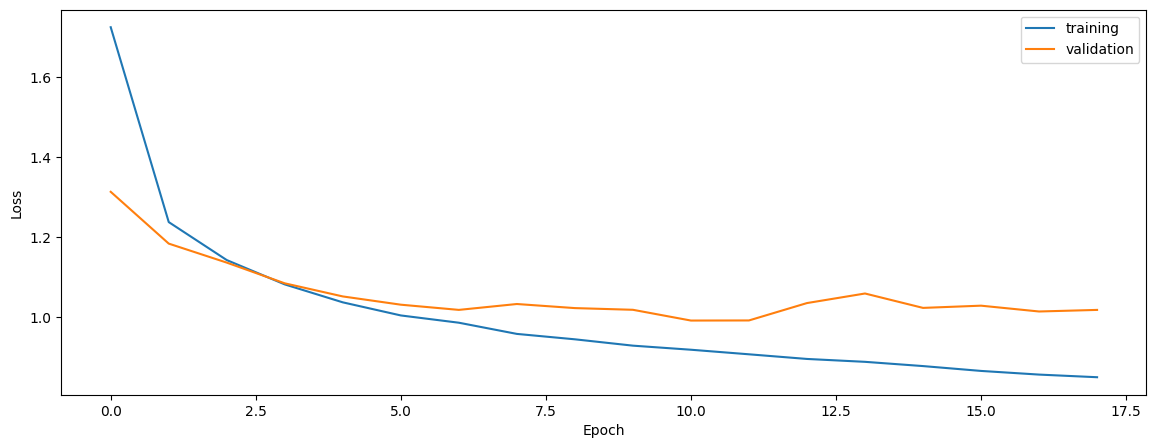

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6312001235100272
0.6080122663360845
0.6142551900604079


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6524996790471852
0.6558092623343983
0.610232786894843


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6503794912703786
0.6492108262727752
0.6206816544642836


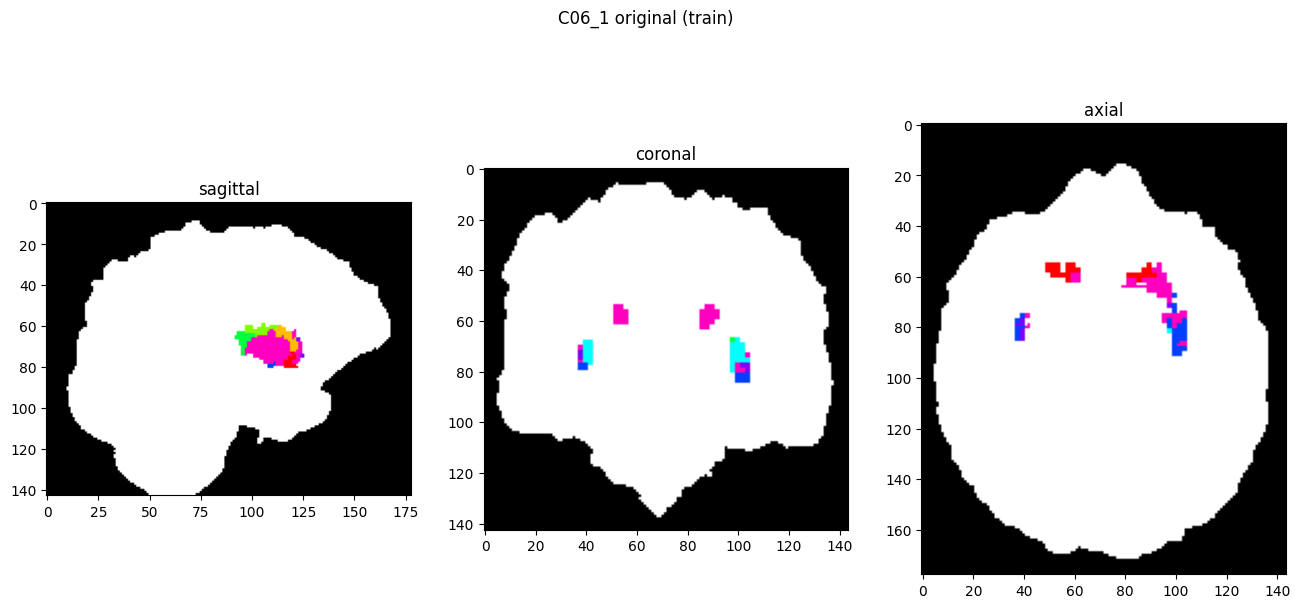

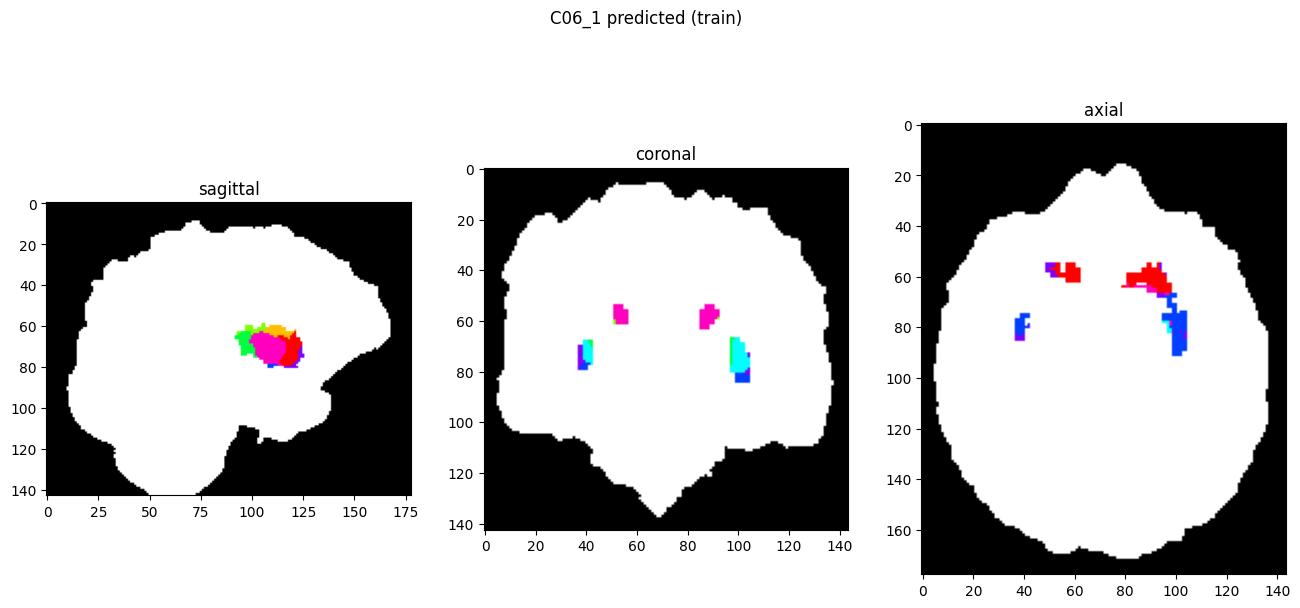

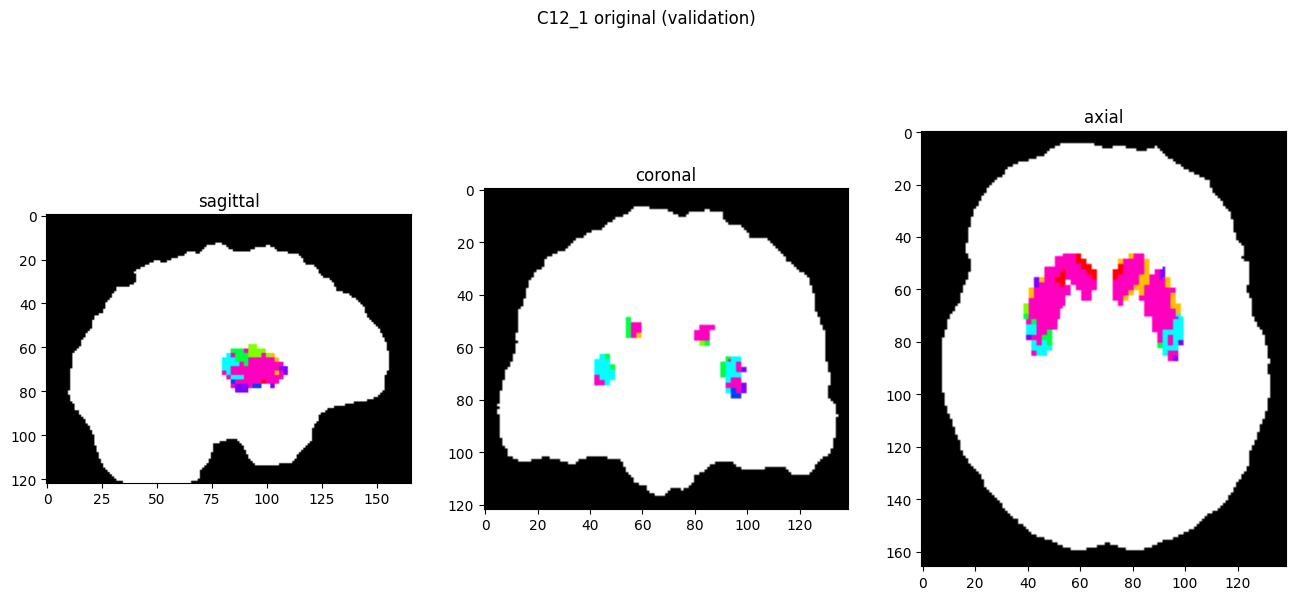

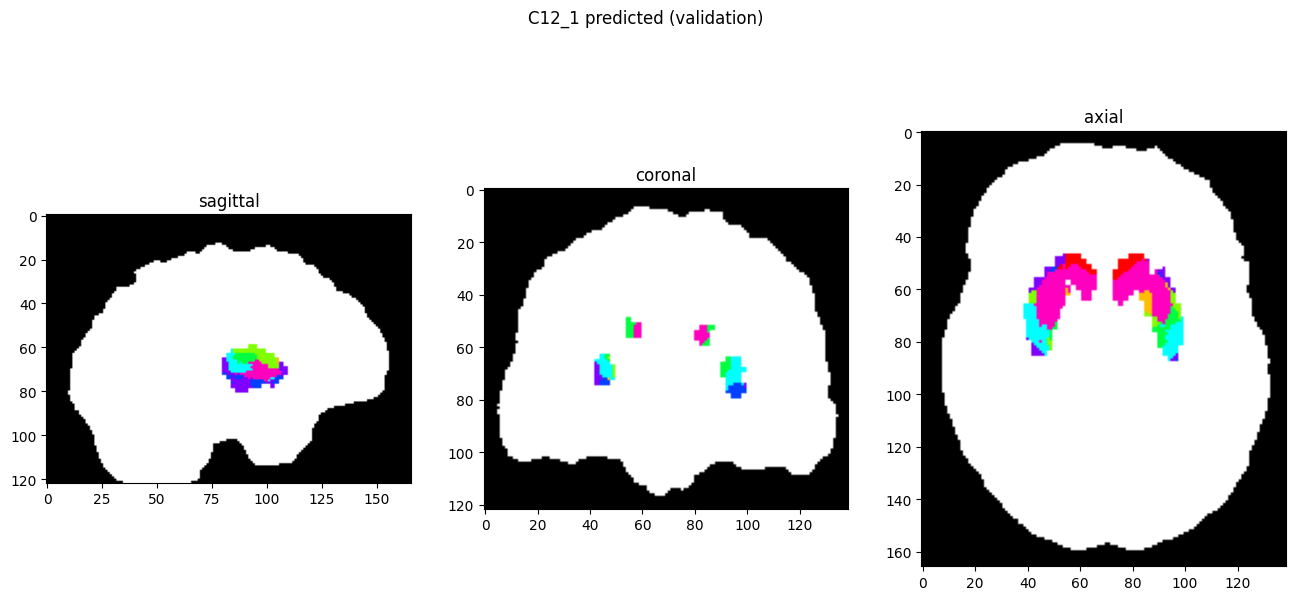

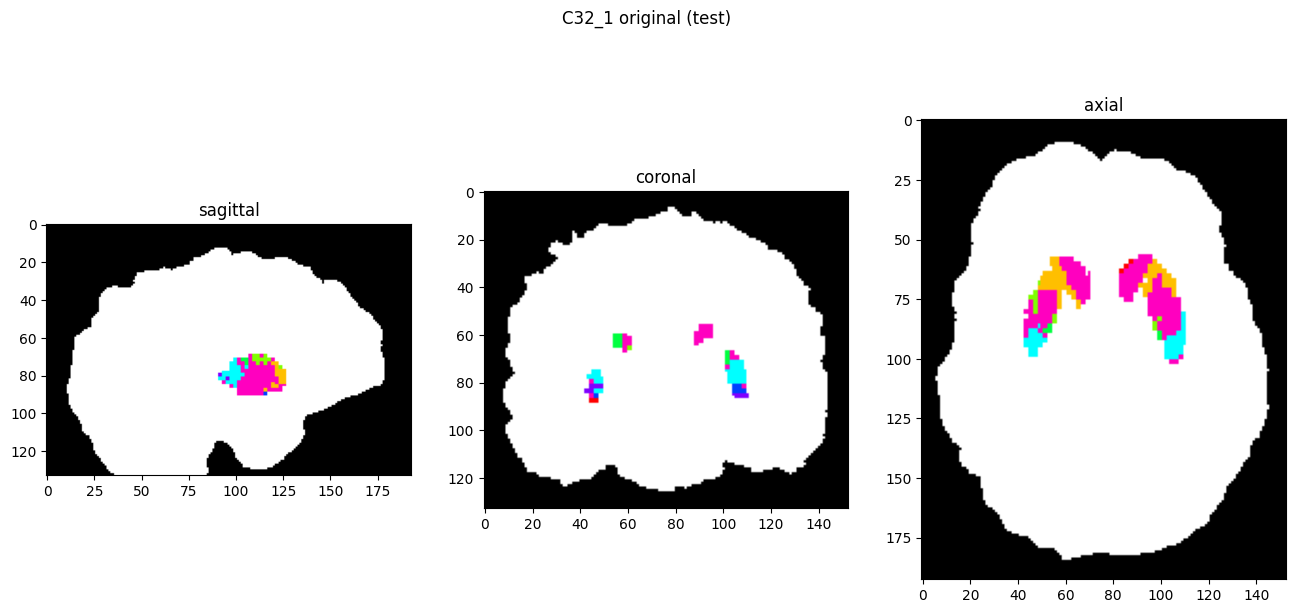

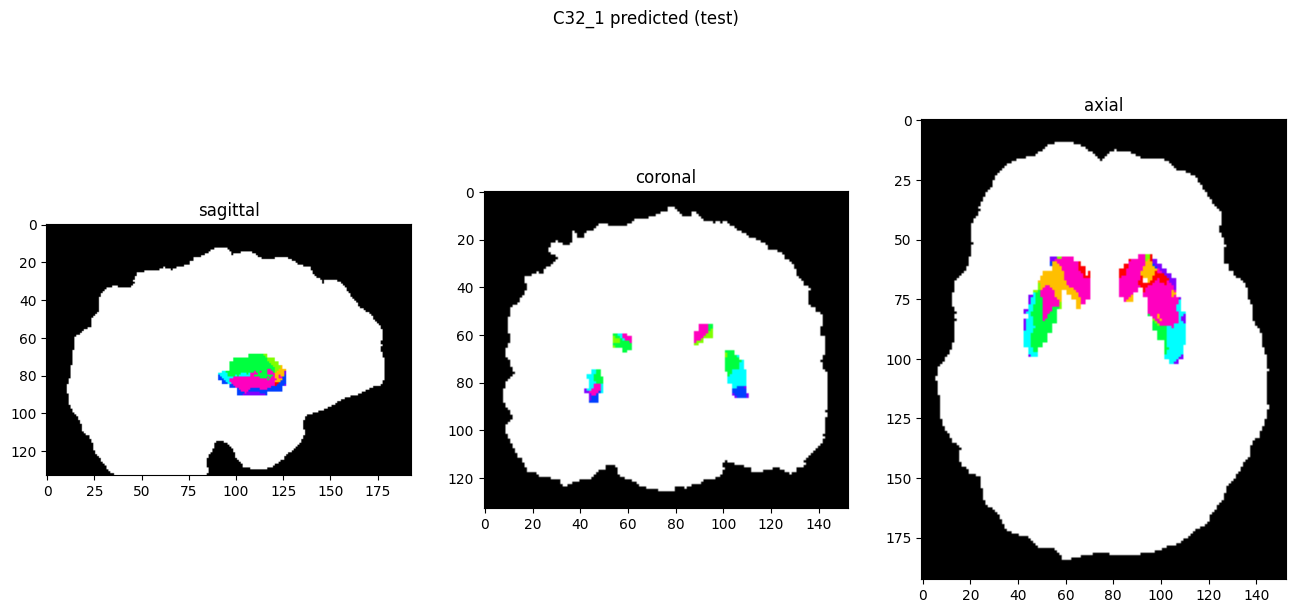

In [10]:
showResults(model, gen, threshold=0)